In [2]:
# !pip install sciann --quiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sciann as sn

from sciann.utils.math import diff
from sciann.constraints import Tie, Data, PDE
from sciann import Variable, Functional

---------------------- SCIANN 0.6.4.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.3.0 
Python Version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)] 



In [2]:
denspt = 9

#Trozo 1

xx_1 = np.linspace(-2,0,2*denspt)
yy_1 = np.linspace(0,1,denspt)
tt_1 = np.linspace(0,30,30*5)

grid_1 = np.meshgrid(xx_1,yy_1,tt_1)

x_1, y_1, t_1 = grid_1
x_1, y_1, t_1 = x_1.flatten(), y_1.flatten(), t_1.flatten()

esp1 = np.stack((x_1,y_1,t_1),axis=1)

#Trozo 2

xx_2 = np.linspace(0,18,18*denspt)
yy_2 = np.linspace(-.5,1,int(1.5*denspt))
tt_2 = tt_1

grid_2= np.meshgrid(xx_2,yy_2,tt_2)

x_2, y_2, t_2 = grid_2
x_2, y_2, t_2 = x_2.flatten(), y_2.flatten(), t_2.flatten()

esp2 = np.stack((x_2,y_2,t_2),axis=1)

esp = np.concatenate ((esp1,esp2))

xesp, yesp, tesp = esp[:,0], esp[:,1], esp[:,2]

In [3]:
initialD = np.where(tesp<=5)[0]
initialD.shape

(56700,)

In [4]:
xesp.shape

(340200,)

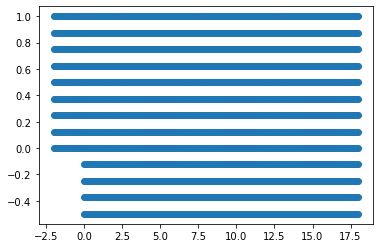

In [5]:
plt.scatter(xesp[np.where(tesp==0)[0]],yesp[np.where(tesp==0)[0]])

In [6]:
rey = 0.0025

In [7]:
activator = 'tanh'

In [17]:
x = Variable("x") 
y = Variable('y')
t = Variable('t')
# u = Functional('u', [x,y,t], 3*[64], activator)
# v = Functional('v', [x,y,t], 3*[64], activator)
psi = Functional('psi', [x,y,t], 3*64, activator)
p = Functional('p', [x,y,t], 3*[64], activator)

u = diff(psi,y)
v = - diff(psi,x)

In [18]:
L1 = diff(u,t) + u*diff(u,x) + v * diff(u,y) - rey * (diff(u,x,order=2)+diff(u,y,order=2))
d1 = Tie(L1,-diff(p,x))
datos1 = [('zeros')]

L2 = diff(v,t) + u*diff(v,x) + v * diff(v,y) - rey * (diff(v,x,order=2)+diff(v,y,order=2))
d2 = Tie(L2,-diff(p,y))
datos2 = [('zeros')]

L3 = diff(u,x) + diff(v,y)
d3 = PDE(L3)
datos3 = [('zeros')]

#Condiciones iniciales
tinicial = np.where(tesp<5)[0]
d4 = Data(u)
datos4 = [(tinicial[:,None],u_pred_Num[tinicial][:,None])]

d5 = Data(v)
datos5 = [(tinicial[:,None],v_pred_Num[tinicial][:,None])]

d6 = Data(p)
datos6 = [(tinicial[:,None],p_pred_Num[tinicial][:,None])]

#Condiciones de contorno
##Definición de bordes

#Borde 1
borde_1 = np.where(xesp ==-2)[0]

#Bordes 2
sup = np.where(yesp == 1)[0]
inf_1 = np.where(yesp == -0.5)[0]
inf_2 = np.intersect1d(np.where(yesp==0)[0],np.where(xesp<=0)[0])
vert = np.intersect1d(np.where(yesp<=0)[0],np.where(xesp<=0)[0])
borde_2 = np.concatenate((sup,inf_1,inf_2,vert))

#Borde 3
borde_3 = np.where(xesp ==18)[0]


#Condiciones sobre el borde 1: entrada de fluido, v=0
entrada = 4*yesp[borde_1]*(1-yesp[borde_1])

d7 = Data(u)
datos7 = [(borde_1[:,None],entrada[:,None])]

d8 = Data(v)
datos8 = [(borde_1[:,None],'zeros')]

#Condiciones sobre los bordes 2: u y v  = 0
d9 = Data(u)
datos9 = [(borde_2[:,None],'zeros')]

d10 = Data(v)
datos10 = [(borde_2[:,None],'zeros')]

#Condiciones sobre el borde 3: p=0 y v=0

d11 = Data(p)
datos11 = [(borde_3[:,None],'zeros')]

d12 = Data(v)
datos12 = [(borde_3[:,None],'zeros')]

#Dummy
dDummy = Data(psi*0.0)
datosDummy = [('zeros')]

restricciones = [d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,dDummy]
datos = datos1+datos2+datos3+datos4+datos5+datos6+datos7+datos8+datos9+datos10+datos11+datos12+datosDummy

m = sn.SciModel([x,y,t], restricciones, 'mae','Adam')

In [19]:

#Entrenamiento del modelo
history = m.train([xesp[:,None],yesp[:,None],tesp[:,None]], datos ,epochs =2500,verbose=1,batch_size=10000,stop_loss_value=0.001)


Total samples: 340200 
Batch size: 10000 
Total batches: 35 

Epoch 1/2500
35/35 [==============================] - 3s 92ms/step - batch: 17.0000 - size: 9720.0000 - loss: 2.6062 - sub_10_loss: 0.0539 - sub_12_loss: 0.0545 - add_21_loss: 4.4227e-09 - Grad__23_loss: 0.3127 - mul_20_loss: 0.0787 - p_loss: 1.0123 - Grad__23_1_loss: 0.6506 - mul_20_1_loss: 0.0648 - Grad__23_2_loss: 0.1253 - mul_20_2_loss: 0.0832 - p_1_loss: 0.1195 - mul_20_3_loss: 0.0507 - mul_29_loss: 0.0000e+00 1s - batch: 9.5000 - size: 9510.0000 - loss: 2.9816 - sub_10_loss: 0.0647 - sub_12_loss: 0.0663 - add_21_loss: 4.6270e-09 - Grad__23_loss: 0.3531 - mul_20_loss: 0.1041 - p_loss: 1.1062 - Grad__23_1_loss: 0.7171 - mul_20_1_loss: 0.0888 - Grad__23_2_loss: 0.1276 - mul_20_2_loss: 0.1106 - p_1_loss: 0.1720 - mul_20_3_loss: 0
Epoch 2/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.8193 - sub_10_loss: 0.0316 - sub_12_loss: 0.0242 - add_21_loss: 3.8356e-09 - Grad__

35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.3768 - sub_10_loss: 0.0187 - sub_12_loss: 0.0072 - add_21_loss: 3.9347e-09 - Grad__23_loss: 0.0990 - mul_20_loss: 0.0074 - p_loss: 0.8461 - Grad__23_1_loss: 0.2566 - mul_20_1_loss: 0.0072 - Grad__23_2_loss: 0.0912 - mul_20_2_loss: 0.0164 - p_1_loss: 0.0245 - mul_20_3_loss: 0.0026 - mul_29_loss: 0.0000e+00
Epoch 20/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.4215 - sub_10_loss: 0.0199 - sub_12_loss: 0.0076 - add_21_loss: 4.0407e-09 - Grad__23_loss: 0.0995 - mul_20_loss: 0.0083 - p_loss: 0.8785 - Grad__23_1_loss: 0.2625 - mul_20_1_loss: 0.0094 - Grad__23_2_loss: 0.0911 - mul_20_2_loss: 0.0169 - p_1_loss: 0.0246 - mul_20_3_loss: 0.0031 - mul_29_loss: 0.0000e+00
Epoch 21/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.3494 - sub_10_loss: 0.0186 - sub_12_loss: 0.0071 - add_21_los

35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.1396 - sub_10_loss: 0.0145 - sub_12_loss: 0.0059 - add_21_loss: 6.0348e-09 - Grad__23_loss: 0.0918 - mul_20_loss: 0.0071 - p_loss: 0.8484 - Grad__23_1_loss: 0.0712 - mul_20_1_loss: 0.0137 - Grad__23_2_loss: 0.0417 - mul_20_2_loss: 0.0116 - p_1_loss: 0.0317 - mul_20_3_loss: 0.0021 - mul_29_loss: 0.0000e+00
Epoch 38/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.1074 - sub_10_loss: 0.0138 - sub_12_loss: 0.0058 - add_21_loss: 6.0720e-09 - Grad__23_loss: 0.0914 - mul_20_loss: 0.0068 - p_loss: 0.8433 - Grad__23_1_loss: 0.0684 - mul_20_1_loss: 0.0117 - Grad__23_2_loss: 0.0374 - mul_20_2_loss: 0.0110 - p_1_loss: 0.0160 - mul_20_3_loss: 0.0019 - mul_29_loss: 0.0000e+00
Epoch 39/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 1.0947 - sub_10_loss: 0.0145 - sub_12_loss: 0.0058 - add_21_los

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.9439 - sub_10_loss: 0.0116 - sub_12_loss: 0.0043 - add_21_loss: 6.1546e-09 - Grad__23_loss: 0.0918 - mul_20_loss: 0.0062 - p_loss: 0.7087 - Grad__23_1_loss: 0.0497 - mul_20_1_loss: 0.0085 - Grad__23_2_loss: 0.0234 - mul_20_2_loss: 0.0084 - p_1_loss: 0.0300 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 57/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.9686 - sub_10_loss: 0.0119 - sub_12_loss: 0.0044 - add_21_loss: 6.0827e-09 - Grad__23_loss: 0.0939 - mul_20_loss: 0.0062 - p_loss: 0.7363 - Grad__23_1_loss: 0.0432 - mul_20_1_loss: 0.0077 - Grad__23_2_loss: 0.0231 - mul_20_2_loss: 0.0082 - p_1_loss: 0.0323 - mul_20_3_loss: 0.0013 - mul_29_loss: 0.0000e+00
Epoch 58/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.9259 - sub_10_loss: 0.0119 - sub_12_loss: 0.0044 - add_21_los

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.8419 - sub_10_loss: 0.0113 - sub_12_loss: 0.0037 - add_21_loss: 6.0642e-09 - Grad__23_loss: 0.0907 - mul_20_loss: 0.0064 - p_loss: 0.6166 - Grad__23_1_loss: 0.0478 - mul_20_1_loss: 0.0085 - Grad__23_2_loss: 0.0214 - mul_20_2_loss: 0.0078 - p_1_loss: 0.0263 - mul_20_3_loss: 0.0014 - mul_29_loss: 0.0000e+00
Epoch 76/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.8640 - sub_10_loss: 0.0108 - sub_12_loss: 0.0036 - add_21_loss: 5.9352e-09 - Grad__23_loss: 0.0902 - mul_20_loss: 0.0059 - p_loss: 0.6508 - Grad__23_1_loss: 0.0397 - mul_20_1_loss: 0.0067 - Grad__23_2_loss: 0.0190 - mul_20_2_loss: 0.0072 - p_1_loss: 0.0291 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 77/2500
35/35 [==============================] - 3s 92ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.8446 - sub_10_loss: 0.0109 - sub_12_loss: 0.0037 - add_21_los

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.8179 - sub_10_loss: 0.0111 - sub_12_loss: 0.0033 - add_21_loss: 5.9131e-09 - Grad__23_loss: 0.0889 - mul_20_loss: 0.0060 - p_loss: 0.6070 - Grad__23_1_loss: 0.0379 - mul_20_1_loss: 0.0057 - Grad__23_2_loss: 0.0200 - mul_20_2_loss: 0.0073 - p_1_loss: 0.0296 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 94/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.9429 - sub_10_loss: 0.0118 - sub_12_loss: 0.0036 - add_21_loss: 6.0208e-09 - Grad__23_loss: 0.0889 - mul_20_loss: 0.0066 - p_loss: 0.6704 - Grad__23_1_loss: 0.0431 - mul_20_1_loss: 0.0081 - Grad__23_2_loss: 0.0194 - mul_20_2_loss: 0.0070 - p_1_loss: 0.0827 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 95/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.9833 - sub_10_loss: 0.0127 - sub_12_loss: 0.0037 - add_21_los

35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.7853 - sub_10_loss: 0.0114 - sub_12_loss: 0.0032 - add_21_loss: 5.9539e-09 - Grad__23_loss: 0.0845 - mul_20_loss: 0.0060 - p_loss: 0.5765 - Grad__23_1_loss: 0.0329 - mul_20_1_loss: 0.0040 - Grad__23_2_loss: 0.0157 - mul_20_2_loss: 0.0069 - p_1_loss: 0.0429 - mul_20_3_loss: 0.0014 - mul_29_loss: 0.0000e+00
Epoch 113/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.7199 - sub_10_loss: 0.0112 - sub_12_loss: 0.0030 - add_21_loss: 5.9154e-09 - Grad__23_loss: 0.0843 - mul_20_loss: 0.0058 - p_loss: 0.5256 - Grad__23_1_loss: 0.0317 - mul_20_1_loss: 0.0038 - Grad__23_2_loss: 0.0144 - mul_20_2_loss: 0.0067 - p_1_loss: 0.0323 - mul_20_3_loss: 9.5288e-04 - mul_29_loss: 0.0000e+00
Epoch 114/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.7243 - sub_10_loss: 0.0115 - sub_12_loss: 0.0030 - add_

35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.6336 - sub_10_loss: 0.0121 - sub_12_loss: 0.0029 - add_21_loss: 5.9811e-09 - Grad__23_loss: 0.0792 - mul_20_loss: 0.0056 - p_loss: 0.4531 - Grad__23_1_loss: 0.0297 - mul_20_1_loss: 0.0029 - Grad__23_2_loss: 0.0141 - mul_20_2_loss: 0.0064 - p_1_loss: 0.0266 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 130/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.6325 - sub_10_loss: 0.0121 - sub_12_loss: 0.0029 - add_21_loss: 6.0803e-09 - Grad__23_loss: 0.0792 - mul_20_loss: 0.0057 - p_loss: 0.4536 - Grad__23_1_loss: 0.0292 - mul_20_1_loss: 0.0028 - Grad__23_2_loss: 0.0140 - mul_20_2_loss: 0.0065 - p_1_loss: 0.0252 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 131/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.6685 - sub_10_loss: 0.0128 - sub_12_loss: 0.0028 - add_21_l

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5834 - sub_10_loss: 0.0130 - sub_12_loss: 0.0028 - add_21_loss: 6.1008e-09 - Grad__23_loss: 0.0725 - mul_20_loss: 0.0054 - p_loss: 0.4141 - Grad__23_1_loss: 0.0272 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0135 - mul_20_2_loss: 0.0063 - p_1_loss: 0.0253 - mul_20_3_loss: 9.9299e-04 - mul_29_loss: 0.0000e+00
Epoch 149/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.6097 - sub_10_loss: 0.0128 - sub_12_loss: 0.0027 - add_21_loss: 6.0610e-09 - Grad__23_loss: 0.0719 - mul_20_loss: 0.0055 - p_loss: 0.4292 - Grad__23_1_loss: 0.0344 - mul_20_1_loss: 0.0025 - Grad__23_2_loss: 0.0158 - mul_20_2_loss: 0.0063 - p_1_loss: 0.0275 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 150/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.6401 - sub_10_loss: 0.0139 - sub_12_loss: 0.0029 - add_

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5663 - sub_10_loss: 0.0140 - sub_12_loss: 0.0027 - add_21_loss: 6.0404e-09 - Grad__23_loss: 0.0664 - mul_20_loss: 0.0057 - p_loss: 0.3972 - Grad__23_1_loss: 0.0294 - mul_20_1_loss: 0.0033 - Grad__23_2_loss: 0.0169 - mul_20_2_loss: 0.0062 - p_1_loss: 0.0236 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 167/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5756 - sub_10_loss: 0.0139 - sub_12_loss: 0.0026 - add_21_loss: 6.1005e-09 - Grad__23_loss: 0.0663 - mul_20_loss: 0.0058 - p_loss: 0.4015 - Grad__23_1_loss: 0.0303 - mul_20_1_loss: 0.0029 - Grad__23_2_loss: 0.0178 - mul_20_2_loss: 0.0064 - p_1_loss: 0.0269 - mul_20_3_loss: 0.0013 - mul_29_loss: 0.0000e+00
Epoch 168/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5328 - sub_10_loss: 0.0139 - sub_12_loss: 0.0027 - add_21_l

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5062 - sub_10_loss: 0.0150 - sub_12_loss: 0.0026 - add_21_loss: 6.1809e-09 - Grad__23_loss: 0.0593 - mul_20_loss: 0.0056 - p_loss: 0.3527 - Grad__23_1_loss: 0.0256 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0158 - mul_20_2_loss: 0.0062 - p_1_loss: 0.0202 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 186/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5133 - sub_10_loss: 0.0147 - sub_12_loss: 0.0025 - add_21_loss: 6.2106e-09 - Grad__23_loss: 0.0580 - mul_20_loss: 0.0055 - p_loss: 0.3674 - Grad__23_1_loss: 0.0252 - mul_20_1_loss: 0.0019 - Grad__23_2_loss: 0.0130 - mul_20_2_loss: 0.0062 - p_1_loss: 0.0178 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 187/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.5192 - sub_10_loss: 0.0151 - sub_12_loss: 0.0025 - add_21_l

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4884 - sub_10_loss: 0.0159 - sub_12_loss: 0.0024 - add_21_loss: 6.3146e-09 - Grad__23_loss: 0.0518 - mul_20_loss: 0.0054 - p_loss: 0.3459 - Grad__23_1_loss: 0.0235 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0127 - mul_20_2_loss: 0.0060 - p_1_loss: 0.0221 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 205/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4531 - sub_10_loss: 0.0156 - sub_12_loss: 0.0024 - add_21_loss: 6.3080e-09 - Grad__23_loss: 0.0511 - mul_20_loss: 0.0053 - p_loss: 0.3192 - Grad__23_1_loss: 0.0230 - mul_20_1_loss: 0.0019 - Grad__23_2_loss: 0.0131 - mul_20_2_loss: 0.0061 - p_1_loss: 0.0143 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 206/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4527 - sub_10_loss: 0.0160 - sub_12_loss: 0.0024 - add_21_l

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4482 - sub_10_loss: 0.0164 - sub_12_loss: 0.0025 - add_21_loss: 6.4885e-09 - Grad__23_loss: 0.0473 - mul_20_loss: 0.0054 - p_loss: 0.3156 - Grad__23_1_loss: 0.0230 - mul_20_1_loss: 0.0022 - Grad__23_2_loss: 0.0145 - mul_20_2_loss: 0.0059 - p_1_loss: 0.0141 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 223/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4875 - sub_10_loss: 0.0163 - sub_12_loss: 0.0023 - add_21_loss: 6.5045e-09 - Grad__23_loss: 0.0468 - mul_20_loss: 0.0054 - p_loss: 0.3536 - Grad__23_1_loss: 0.0216 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0126 - mul_20_2_loss: 0.0058 - p_1_loss: 0.0197 - mul_20_3_loss: 0.0011 - mul_29_loss: 0.0000e+00
Epoch 224/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4418 - sub_10_loss: 0.0162 - sub_12_loss: 0.0023 - add_21_l

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3919 - sub_10_loss: 0.0165 - sub_12_loss: 0.0023 - add_21_loss: 6.6772e-09 - Grad__23_loss: 0.0444 - mul_20_loss: 0.0056 - p_loss: 0.2707 - Grad__23_1_loss: 0.0193 - mul_20_1_loss: 0.0029 - Grad__23_2_loss: 0.0128 - mul_20_2_loss: 0.0056 - p_1_loss: 0.0107 - mul_20_3_loss: 0.0010 - mul_29_loss: 0.0000e+00
Epoch 242/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3875 - sub_10_loss: 0.0164 - sub_12_loss: 0.0023 - add_21_loss: 6.6283e-09 - Grad__23_loss: 0.0442 - mul_20_loss: 0.0052 - p_loss: 0.2696 - Grad__23_1_loss: 0.0190 - mul_20_1_loss: 0.0019 - Grad__23_2_loss: 0.0125 - mul_20_2_loss: 0.0055 - p_1_loss: 0.0100 - mul_20_3_loss: 8.6105e-04 - mul_29_loss: 0.0000e+00
Epoch 243/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4000 - sub_10_loss: 0.0164 - sub_12_loss: 0.0024 - add_

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.4046 - sub_10_loss: 0.0167 - sub_12_loss: 0.0024 - add_21_loss: 6.7236e-09 - Grad__23_loss: 0.0445 - mul_20_loss: 0.0057 - p_loss: 0.2739 - Grad__23_1_loss: 0.0190 - mul_20_1_loss: 0.0040 - Grad__23_2_loss: 0.0136 - mul_20_2_loss: 0.0058 - p_1_loss: 0.0178 - mul_20_3_loss: 0.0010 - mul_29_loss: 0.0000e+00
Epoch 260/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3914 - sub_10_loss: 0.0164 - sub_12_loss: 0.0024 - add_21_loss: 6.9324e-09 - Grad__23_loss: 0.0435 - mul_20_loss: 0.0055 - p_loss: 0.2668 - Grad__23_1_loss: 0.0168 - mul_20_1_loss: 0.0032 - Grad__23_2_loss: 0.0134 - mul_20_2_loss: 0.0057 - p_1_loss: 0.0168 - mul_20_3_loss: 8.7809e-04 - mul_29_loss: 0.0000e+00
Epoch 261/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3857 - sub_10_loss: 0.0161 - sub_12_loss: 0.0023 - add_

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3603 - sub_10_loss: 0.0164 - sub_12_loss: 0.0023 - add_21_loss: 6.8652e-09 - Grad__23_loss: 0.0430 - mul_20_loss: 0.0054 - p_loss: 0.2474 - Grad__23_1_loss: 0.0145 - mul_20_1_loss: 0.0027 - Grad__23_2_loss: 0.0123 - mul_20_2_loss: 0.0056 - p_1_loss: 0.0100 - mul_20_3_loss: 7.1171e-04 - mul_29_loss: 0.0000e+00
Epoch 276/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3721 - sub_10_loss: 0.0169 - sub_12_loss: 0.0024 - add_21_loss: 7.0215e-09 - Grad__23_loss: 0.0431 - mul_20_loss: 0.0053 - p_loss: 0.2582 - Grad__23_1_loss: 0.0154 - mul_20_1_loss: 0.0024 - Grad__23_2_loss: 0.0135 - mul_20_2_loss: 0.0054 - p_1_loss: 0.0087 - mul_20_3_loss: 7.3702e-04 - mul_29_loss: 0.0000e+00
Epoch 277/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3460 - sub_10_loss: 0.0165 - sub_12_loss: 0.0023 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3522 - sub_10_loss: 0.0163 - sub_12_loss: 0.0023 - add_21_loss: 6.9799e-09 - Grad__23_loss: 0.0427 - mul_20_loss: 0.0050 - p_loss: 0.2440 - Grad__23_1_loss: 0.0136 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0111 - mul_20_2_loss: 0.0050 - p_1_loss: 0.0100 - mul_20_3_loss: 5.9851e-04 - mul_29_loss: 0.0000e+00
Epoch 294/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3372 - sub_10_loss: 0.0166 - sub_12_loss: 0.0024 - add_21_loss: 6.9869e-09 - Grad__23_loss: 0.0425 - mul_20_loss: 0.0052 - p_loss: 0.2283 - Grad__23_1_loss: 0.0137 - mul_20_1_loss: 0.0028 - Grad__23_2_loss: 0.0114 - mul_20_2_loss: 0.0053 - p_1_loss: 0.0084 - mul_20_3_loss: 6.4250e-04 - mul_29_loss: 0.0000e+00
Epoch 295/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3483 - sub_10_loss: 0.0166 - sub_12_loss: 0.0025 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3370 - sub_10_loss: 0.0162 - sub_12_loss: 0.0022 - add_21_loss: 7.2317e-09 - Grad__23_loss: 0.0416 - mul_20_loss: 0.0050 - p_loss: 0.2337 - Grad__23_1_loss: 0.0104 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0107 - mul_20_2_loss: 0.0050 - p_1_loss: 0.0099 - mul_20_3_loss: 5.5088e-04 - mul_29_loss: 0.0000e+00
Epoch 312/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3313 - sub_10_loss: 0.0170 - sub_12_loss: 0.0023 - add_21_loss: 7.0856e-09 - Grad__23_loss: 0.0419 - mul_20_loss: 0.0050 - p_loss: 0.2234 - Grad__23_1_loss: 0.0113 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0113 - mul_20_2_loss: 0.0050 - p_1_loss: 0.0118 - mul_20_3_loss: 6.2790e-04 - mul_29_loss: 0.0000e+00
Epoch 313/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3176 - sub_10_loss: 0.0164 - sub_12_loss: 0.0022 - 

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3092 - sub_10_loss: 0.0162 - sub_12_loss: 0.0021 - add_21_loss: 7.2328e-09 - Grad__23_loss: 0.0410 - mul_20_loss: 0.0051 - p_loss: 0.2071 - Grad__23_1_loss: 0.0092 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0117 - mul_20_3_loss: 5.0014e-04 - mul_29_loss: 0.0000e+00
Epoch 331/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3205 - sub_10_loss: 0.0163 - sub_12_loss: 0.0021 - add_21_loss: 7.2341e-09 - Grad__23_loss: 0.0411 - mul_20_loss: 0.0051 - p_loss: 0.2229 - Grad__23_1_loss: 0.0091 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0070 - mul_20_3_loss: 5.5744e-04 - mul_29_loss: 0.0000e+00
Epoch 332/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3338 - sub_10_loss: 0.0166 - sub_12_loss: 0.0022 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3021 - sub_10_loss: 0.0165 - sub_12_loss: 0.0021 - add_21_loss: 7.3225e-09 - Grad__23_loss: 0.0416 - mul_20_loss: 0.0052 - p_loss: 0.2016 - Grad__23_1_loss: 0.0094 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0105 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0077 - mul_20_3_loss: 6.6385e-04 - mul_29_loss: 0.0000e+00
Epoch 350/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.3049 - sub_10_loss: 0.0164 - sub_12_loss: 0.0020 - add_21_loss: 7.3182e-09 - Grad__23_loss: 0.0410 - mul_20_loss: 0.0051 - p_loss: 0.2070 - Grad__23_1_loss: 0.0101 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0048 - p_1_loss: 0.0062 - mul_20_3_loss: 5.7158e-04 - mul_29_loss: 0.0000e+00
Epoch 351/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2984 - sub_10_loss: 0.0166 - sub_12_loss: 0.0022 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2872 - sub_10_loss: 0.0165 - sub_12_loss: 0.0020 - add_21_loss: 7.3582e-09 - Grad__23_loss: 0.0409 - mul_20_loss: 0.0050 - p_loss: 0.1903 - Grad__23_1_loss: 0.0083 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0093 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0085 - mul_20_3_loss: 4.7966e-04 - mul_29_loss: 0.0000e+00 0s - batch: 15.5000 - size: 9693.7500 - loss: 0.2886 - sub_10_loss: 0.0166 - sub_12_loss: 0.0020 - add_21_loss: 7.3720e-09 - Grad__23_loss: 0.0411 - mul_20_loss: 0.0050 - p_loss: 0.1918 - Grad__23_1_loss: 0.0082 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0084 - mul_20_3_loss: 4.8893e-04 - mul_29_loss: 0.00
Epoch 368/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2975 - sub_10_loss: 0.0165 - sub_12_loss: 0.0022 - add_21_loss: 7.4136e-09 - Grad__23_loss: 0.0417 - mul_20_loss: 0.0054 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2685 - sub_10_loss: 0.0166 - sub_12_loss: 0.0020 - add_21_loss: 7.3125e-09 - Grad__23_loss: 0.0406 - mul_20_loss: 0.0051 - p_loss: 0.1712 - Grad__23_1_loss: 0.0091 - mul_20_1_loss: 0.0030 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0056 - mul_20_3_loss: 5.0431e-04 - mul_29_loss: 0.0000e+00
Epoch 386/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2672 - sub_10_loss: 0.0167 - sub_12_loss: 0.0019 - add_21_loss: 7.2886e-09 - Grad__23_loss: 0.0406 - mul_20_loss: 0.0050 - p_loss: 0.1722 - Grad__23_1_loss: 0.0076 - mul_20_1_loss: 0.0022 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0068 - mul_20_3_loss: 4.7241e-04 - mul_29_loss: 0.0000e+00
Epoch 387/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2837 - sub_10_loss: 0.0164 - sub_12_loss: 0.0021 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2598 - sub_10_loss: 0.0162 - sub_12_loss: 0.0019 - add_21_loss: 7.3049e-09 - Grad__23_loss: 0.0396 - mul_20_loss: 0.0050 - p_loss: 0.1646 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 0.0021 - Grad__23_2_loss: 0.0093 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0080 - mul_20_3_loss: 5.6282e-04 - mul_29_loss: 0.0000e+00
Epoch 405/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2584 - sub_10_loss: 0.0166 - sub_12_loss: 0.0020 - add_21_loss: 7.4476e-09 - Grad__23_loss: 0.0409 - mul_20_loss: 0.0050 - p_loss: 0.1619 - Grad__23_1_loss: 0.0088 - mul_20_1_loss: 0.0026 - Grad__23_2_loss: 0.0106 - mul_20_2_loss: 0.0048 - p_1_loss: 0.0046 - mul_20_3_loss: 5.3283e-04 - mul_29_loss: 0.0000e+00
Epoch 406/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2733 - sub_10_loss: 0.0161 - sub_12_loss: 0.0020 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2488 - sub_10_loss: 0.0162 - sub_12_loss: 0.0018 - add_21_loss: 7.4997e-09 - Grad__23_loss: 0.0401 - mul_20_loss: 0.0051 - p_loss: 0.1564 - Grad__23_1_loss: 0.0081 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0097 - mul_20_2_loss: 0.0046 - p_1_loss: 0.0046 - mul_20_3_loss: 4.4842e-04 - mul_29_loss: 0.0000e+00
Epoch 424/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2616 - sub_10_loss: 0.0162 - sub_12_loss: 0.0018 - add_21_loss: 7.5883e-09 - Grad__23_loss: 0.0399 - mul_20_loss: 0.0050 - p_loss: 0.1667 - Grad__23_1_loss: 0.0072 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0104 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0076 - mul_20_3_loss: 4.8243e-04 - mul_29_loss: 0.0000e+00
Epoch 425/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2522 - sub_10_loss: 0.0161 - sub_12_loss: 0.0018 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2380 - sub_10_loss: 0.0163 - sub_12_loss: 0.0018 - add_21_loss: 7.5736e-09 - Grad__23_loss: 0.0391 - mul_20_loss: 0.0048 - p_loss: 0.1497 - Grad__23_1_loss: 0.0067 - mul_20_1_loss: 9.7394e-04 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0045 - p_1_loss: 0.0047 - mul_20_3_loss: 4.5785e-04 - mul_29_loss: 0.0000e+00
Epoch 443/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2378 - sub_10_loss: 0.0161 - sub_12_loss: 0.0018 - add_21_loss: 7.5509e-09 - Grad__23_loss: 0.0392 - mul_20_loss: 0.0049 - p_loss: 0.1477 - Grad__23_1_loss: 0.0072 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0046 - p_1_loss: 0.0055 - mul_20_3_loss: 4.9004e-04 - mul_29_loss: 0.0000e+00
Epoch 444/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2527 - sub_10_loss: 0.0166 - sub_12_loss: 0.001

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2339 - sub_10_loss: 0.0163 - sub_12_loss: 0.0018 - add_21_loss: 7.4659e-09 - Grad__23_loss: 0.0393 - mul_20_loss: 0.0049 - p_loss: 0.1418 - Grad__23_1_loss: 0.0080 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0065 - mul_20_3_loss: 4.8053e-04 - mul_29_loss: 0.0000e+00
Epoch 462/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2300 - sub_10_loss: 0.0161 - sub_12_loss: 0.0017 - add_21_loss: 7.4190e-09 - Grad__23_loss: 0.0392 - mul_20_loss: 0.0049 - p_loss: 0.1394 - Grad__23_1_loss: 0.0071 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0062 - mul_20_3_loss: 5.1939e-04 - mul_29_loss: 0.0000e+00
Epoch 463/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2489 - sub_10_loss: 0.0164 - sub_12_loss: 0.0018 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2378 - sub_10_loss: 0.0161 - sub_12_loss: 0.0017 - add_21_loss: 7.4595e-09 - Grad__23_loss: 0.0398 - mul_20_loss: 0.0051 - p_loss: 0.1445 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0096 - mul_20_2_loss: 0.0045 - p_1_loss: 0.0066 - mul_20_3_loss: 4.6369e-04 - mul_29_loss: 0.0000e+00
Epoch 481/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2356 - sub_10_loss: 0.0172 - sub_12_loss: 0.0018 - add_21_loss: 7.2906e-09 - Grad__23_loss: 0.0397 - mul_20_loss: 0.0051 - p_loss: 0.1392 - Grad__23_1_loss: 0.0081 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0101 - mul_20_2_loss: 0.0046 - p_1_loss: 0.0077 - mul_20_3_loss: 4.9817e-04 - mul_29_loss: 0.0000e+00
Epoch 482/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2601 - sub_10_loss: 0.0163 - sub_12_loss: 0.0017 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2199 - sub_10_loss: 0.0163 - sub_12_loss: 0.0017 - add_21_loss: 7.5032e-09 - Grad__23_loss: 0.0391 - mul_20_loss: 0.0050 - p_loss: 0.1269 - Grad__23_1_loss: 0.0085 - mul_20_1_loss: 0.0021 - Grad__23_2_loss: 0.0109 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0042 - mul_20_3_loss: 5.1879e-04 - mul_29_loss: 0.0000e+00
Epoch 500/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2134 - sub_10_loss: 0.0161 - sub_12_loss: 0.0016 - add_21_loss: 7.5651e-09 - Grad__23_loss: 0.0384 - mul_20_loss: 0.0049 - p_loss: 0.1265 - Grad__23_1_loss: 0.0066 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0047 - mul_20_3_loss: 4.3530e-04 - mul_29_loss: 0.0000e+00
Epoch 501/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2465 - sub_10_loss: 0.0163 - sub_12_loss: 0.0017 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2184 - sub_10_loss: 0.0165 - sub_12_loss: 0.0016 - add_21_loss: 7.6028e-09 - Grad__23_loss: 0.0398 - mul_20_loss: 0.0050 - p_loss: 0.1229 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0082 - mul_20_3_loss: 4.6026e-04 - mul_29_loss: 0.0000e+00
Epoch 519/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2178 - sub_10_loss: 0.0162 - sub_12_loss: 0.0017 - add_21_loss: 7.5845e-09 - Grad__23_loss: 0.0394 - mul_20_loss: 0.0052 - p_loss: 0.1226 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0032 - Grad__23_2_loss: 0.0094 - mul_20_2_loss: 0.0045 - p_1_loss: 0.0074 - mul_20_3_loss: 4.1449e-04 - mul_29_loss: 0.0000e+00
Epoch 520/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2189 - sub_10_loss: 0.0163 - sub_12_loss: 0.0016 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2551 - sub_10_loss: 0.0185 - sub_12_loss: 0.0022 - add_21_loss: 7.5908e-09 - Grad__23_loss: 0.0420 - mul_20_loss: 0.0068 - p_loss: 0.1159 - Grad__23_1_loss: 0.0307 - mul_20_1_loss: 0.0066 - Grad__23_2_loss: 0.0200 - mul_20_2_loss: 0.0068 - p_1_loss: 0.0045 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 537/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2201 - sub_10_loss: 0.0166 - sub_12_loss: 0.0018 - add_21_loss: 7.5222e-09 - Grad__23_loss: 0.0391 - mul_20_loss: 0.0052 - p_loss: 0.1234 - Grad__23_1_loss: 0.0086 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0106 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0069 - mul_20_3_loss: 7.1086e-04 - mul_29_loss: 0.0000e+00
Epoch 538/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2250 - sub_10_loss: 0.0165 - sub_12_loss: 0.0017 - add_

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2159 - sub_10_loss: 0.0161 - sub_12_loss: 0.0016 - add_21_loss: 7.4456e-09 - Grad__23_loss: 0.0382 - mul_20_loss: 0.0051 - p_loss: 0.1208 - Grad__23_1_loss: 0.0086 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0101 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0085 - mul_20_3_loss: 6.9603e-04 - mul_29_loss: 0.0000e+00
Epoch 555/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2102 - sub_10_loss: 0.0161 - sub_12_loss: 0.0015 - add_21_loss: 7.5421e-09 - Grad__23_loss: 0.0384 - mul_20_loss: 0.0048 - p_loss: 0.1203 - Grad__23_1_loss: 0.0074 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0065 - mul_20_3_loss: 3.9270e-04 - mul_29_loss: 0.0000e+00
Epoch 556/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2110 - sub_10_loss: 0.0167 - sub_12_loss: 0.0016 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2152 - sub_10_loss: 0.0170 - sub_12_loss: 0.0018 - add_21_loss: 7.5462e-09 - Grad__23_loss: 0.0400 - mul_20_loss: 0.0053 - p_loss: 0.1045 - Grad__23_1_loss: 0.0202 - mul_20_1_loss: 0.0035 - Grad__23_2_loss: 0.0131 - mul_20_2_loss: 0.0051 - p_1_loss: 0.0036 - mul_20_3_loss: 9.5216e-04 - mul_29_loss: 0.0000e+00
Epoch 573/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2031 - sub_10_loss: 0.0162 - sub_12_loss: 0.0015 - add_21_loss: 7.5455e-09 - Grad__23_loss: 0.0381 - mul_20_loss: 0.0053 - p_loss: 0.1120 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0086 - mul_20_3_loss: 4.1197e-04 - mul_29_loss: 0.0000e+00
Epoch 574/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2107 - sub_10_loss: 0.0164 - sub_12_loss: 0.0017 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1902 - sub_10_loss: 0.0163 - sub_12_loss: 0.0015 - add_21_loss: 7.7033e-09 - Grad__23_loss: 0.0376 - mul_20_loss: 0.0048 - p_loss: 0.1037 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0071 - mul_20_3_loss: 3.4919e-04 - mul_29_loss: 0.0000e+00
Epoch 592/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1886 - sub_10_loss: 0.0166 - sub_12_loss: 0.0016 - add_21_loss: 7.6228e-09 - Grad__23_loss: 0.0383 - mul_20_loss: 0.0049 - p_loss: 0.1019 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0044 - mul_20_3_loss: 4.5141e-04 - mul_29_loss: 0.0000e+00
Epoch 593/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1969 - sub_10_loss: 0.0161 - sub_12_loss: 0.0015 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.2008 - sub_10_loss: 0.0171 - sub_12_loss: 0.0017 - add_21_loss: 7.6311e-09 - Grad__23_loss: 0.0382 - mul_20_loss: 0.0054 - p_loss: 0.0992 - Grad__23_1_loss: 0.0140 - mul_20_1_loss: 0.0025 - Grad__23_2_loss: 0.0116 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0056 - mul_20_3_loss: 7.2710e-04 - mul_29_loss: 0.0000e+00 0s - batch: 16.0000 - size: 9703.0303 - loss: 0.2020 - sub_10_loss: 0.0171 - sub_12_loss: 0.0016 - add_21_loss: 7.6136e-09 - Grad__23_loss: 0.0382 - mul_20_loss: 0.0054 - p_loss: 0.0993 - Grad__23_1_loss: 0.0145 - mul_20_1_loss: 0.0026 - Grad__23_2_loss: 0.0118 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0057 - mul_20_3_loss: 7.5122e-04 - mul_29_loss: 0.00
Epoch 611/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1838 - sub_10_loss: 0.0161 - sub_12_loss: 0.0015 - add_21_loss: 7.6448e-09 - Grad__23_loss: 0.0376 - mul_20_loss: 0.0049 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1832 - sub_10_loss: 0.0161 - sub_12_loss: 0.0014 - add_21_loss: 7.6820e-09 - Grad__23_loss: 0.0374 - mul_20_loss: 0.0048 - p_loss: 0.0973 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0048 - mul_20_3_loss: 4.0664e-04 - mul_29_loss: 0.0000e+00
Epoch 629/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1913 - sub_10_loss: 0.0160 - sub_12_loss: 0.0014 - add_21_loss: 7.6601e-09 - Grad__23_loss: 0.0374 - mul_20_loss: 0.0047 - p_loss: 0.0983 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0101 - mul_20_3_loss: 4.7102e-04 - mul_29_loss: 0.0000e+00
Epoch 630/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1910 - sub_10_loss: 0.0163 - sub_12_loss: 0.0015 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1870 - sub_10_loss: 0.0164 - sub_12_loss: 0.0014 - add_21_loss: 7.6435e-09 - Grad__23_loss: 0.0380 - mul_20_loss: 0.0051 - p_loss: 0.0893 - Grad__23_1_loss: 0.0122 - mul_20_1_loss: 0.0026 - Grad__23_2_loss: 0.0124 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0048 - mul_20_3_loss: 5.6465e-04 - mul_29_loss: 0.0000e+00
Epoch 647/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1799 - sub_10_loss: 0.0160 - sub_12_loss: 0.0014 - add_21_loss: 7.5107e-09 - Grad__23_loss: 0.0380 - mul_20_loss: 0.0049 - p_loss: 0.0890 - Grad__23_1_loss: 0.0088 - mul_20_1_loss: 0.0021 - Grad__23_2_loss: 0.0104 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0045 - mul_20_3_loss: 4.8691e-04 - mul_29_loss: 0.0000e+00
Epoch 648/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1794 - sub_10_loss: 0.0166 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1797 - sub_10_loss: 0.0167 - sub_12_loss: 0.0015 - add_21_loss: 7.5896e-09 - Grad__23_loss: 0.0376 - mul_20_loss: 0.0052 - p_loss: 0.0849 - Grad__23_1_loss: 0.0118 - mul_20_1_loss: 0.0025 - Grad__23_2_loss: 0.0104 - mul_20_2_loss: 0.0047 - p_1_loss: 0.0037 - mul_20_3_loss: 6.2865e-04 - mul_29_loss: 0.0000e+00
Epoch 665/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1756 - sub_10_loss: 0.0160 - sub_12_loss: 0.0015 - add_21_loss: 7.5947e-09 - Grad__23_loss: 0.0379 - mul_20_loss: 0.0047 - p_loss: 0.0873 - Grad__23_1_loss: 0.0071 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0061 - mul_20_3_loss: 3.9386e-04 - mul_29_loss: 0.0000e+00
Epoch 666/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1884 - sub_10_loss: 0.0159 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1864 - sub_10_loss: 0.0165 - sub_12_loss: 0.0014 - add_21_loss: 7.5804e-09 - Grad__23_loss: 0.0391 - mul_20_loss: 0.0048 - p_loss: 0.0867 - Grad__23_1_loss: 0.0126 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0136 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0054 - mul_20_3_loss: 5.5998e-04 - mul_29_loss: 0.0000e+00
Epoch 683/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1849 - sub_10_loss: 0.0161 - sub_12_loss: 0.0014 - add_21_loss: 7.6276e-09 - Grad__23_loss: 0.0373 - mul_20_loss: 0.0049 - p_loss: 0.0931 - Grad__23_1_loss: 0.0069 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0097 - mul_20_3_loss: 5.3248e-04 - mul_29_loss: 0.0000e+00
Epoch 684/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1864 - sub_10_loss: 0.0164 - sub_12_loss: 0.0015 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1791 - sub_10_loss: 0.0161 - sub_12_loss: 0.0013 - add_21_loss: 7.6346e-09 - Grad__23_loss: 0.0379 - mul_20_loss: 0.0049 - p_loss: 0.0894 - Grad__23_1_loss: 0.0081 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0051 - mul_20_3_loss: 4.0455e-04 - mul_29_loss: 0.0000e+00
Epoch 702/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1683 - sub_10_loss: 0.0159 - sub_12_loss: 0.0014 - add_21_loss: 7.8112e-09 - Grad__23_loss: 0.0375 - mul_20_loss: 0.0050 - p_loss: 0.0785 - Grad__23_1_loss: 0.0085 - mul_20_1_loss: 0.0022 - Grad__23_2_loss: 0.0111 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0033 - mul_20_3_loss: 5.9136e-04 - mul_29_loss: 0.0000e+00
Epoch 703/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1672 - sub_10_loss: 0.0164 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1651 - sub_10_loss: 0.0159 - sub_12_loss: 0.0013 - add_21_loss: 7.7038e-09 - Grad__23_loss: 0.0375 - mul_20_loss: 0.0046 - p_loss: 0.0787 - Grad__23_1_loss: 0.0059 - mul_20_1_loss: 9.4017e-04 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0071 - mul_20_3_loss: 3.5566e-04 - mul_29_loss: 0.0000e+00
Epoch 721/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1699 - sub_10_loss: 0.0159 - sub_12_loss: 0.0014 - add_21_loss: 7.7992e-09 - Grad__23_loss: 0.0370 - mul_20_loss: 0.0050 - p_loss: 0.0778 - Grad__23_1_loss: 0.0088 - mul_20_1_loss: 0.0019 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0074 - mul_20_3_loss: 5.1929e-04 - mul_29_loss: 0.0000e+00
Epoch 722/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1619 - sub_10_loss: 0.0157 - sub_12_loss: 0.001

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1661 - sub_10_loss: 0.0160 - sub_12_loss: 0.0013 - add_21_loss: 7.8034e-09 - Grad__23_loss: 0.0371 - mul_20_loss: 0.0048 - p_loss: 0.0777 - Grad__23_1_loss: 0.0085 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0045 - mul_20_3_loss: 4.5555e-04 - mul_29_loss: 0.0000e+00
Epoch 739/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1644 - sub_10_loss: 0.0161 - sub_12_loss: 0.0014 - add_21_loss: 7.6683e-09 - Grad__23_loss: 0.0381 - mul_20_loss: 0.0049 - p_loss: 0.0735 - Grad__23_1_loss: 0.0088 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0054 - mul_20_3_loss: 4.0472e-04 - mul_29_loss: 0.0000e+00
Epoch 740/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1577 - sub_10_loss: 0.0157 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1719 - sub_10_loss: 0.0162 - sub_12_loss: 0.0014 - add_21_loss: 7.7704e-09 - Grad__23_loss: 0.0380 - mul_20_loss: 0.0049 - p_loss: 0.0795 - Grad__23_1_loss: 0.0101 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0107 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0044 - mul_20_3_loss: 5.1755e-04 - mul_29_loss: 0.0000e+00
Epoch 758/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1678 - sub_10_loss: 0.0156 - sub_12_loss: 0.0014 - add_21_loss: 7.5115e-09 - Grad__23_loss: 0.0376 - mul_20_loss: 0.0048 - p_loss: 0.0789 - Grad__23_1_loss: 0.0071 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0069 - mul_20_3_loss: 4.2843e-04 - mul_29_loss: 0.0000e+00
Epoch 759/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1760 - sub_10_loss: 0.0158 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1521 - sub_10_loss: 0.0159 - sub_12_loss: 0.0014 - add_21_loss: 7.5372e-09 - Grad__23_loss: 0.0374 - mul_20_loss: 0.0049 - p_loss: 0.0646 - Grad__23_1_loss: 0.0097 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0099 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0021 - mul_20_3_loss: 5.4809e-04 - mul_29_loss: 0.0000e+00
Epoch 777/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1496 - sub_10_loss: 0.0154 - sub_12_loss: 0.0013 - add_21_loss: 7.6557e-09 - Grad__23_loss: 0.0366 - mul_20_loss: 0.0047 - p_loss: 0.0676 - Grad__23_1_loss: 0.0047 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0058 - mul_20_3_loss: 3.8624e-04 - mul_29_loss: 0.0000e+00
Epoch 778/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1522 - sub_10_loss: 0.0155 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1480 - sub_10_loss: 0.0153 - sub_12_loss: 0.0013 - add_21_loss: 7.5165e-09 - Grad__23_loss: 0.0365 - mul_20_loss: 0.0047 - p_loss: 0.0637 - Grad__23_1_loss: 0.0068 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0050 - mul_20_3_loss: 3.5976e-04 - mul_29_loss: 0.0000e+00
Epoch 796/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1602 - sub_10_loss: 0.0151 - sub_12_loss: 0.0013 - add_21_loss: 7.6075e-09 - Grad__23_loss: 0.0378 - mul_20_loss: 0.0049 - p_loss: 0.0662 - Grad__23_1_loss: 0.0106 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0117 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0069 - mul_20_3_loss: 4.2274e-04 - mul_29_loss: 0.0000e+00
Epoch 797/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1605 - sub_10_loss: 0.0152 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1632 - sub_10_loss: 0.0158 - sub_12_loss: 0.0014 - add_21_loss: 7.6085e-09 - Grad__23_loss: 0.0374 - mul_20_loss: 0.0047 - p_loss: 0.0601 - Grad__23_1_loss: 0.0210 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0120 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0039 - mul_20_3_loss: 3.4074e-04 - mul_29_loss: 0.0000e+00
Epoch 815/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1775 - sub_10_loss: 0.0166 - sub_12_loss: 0.0017 - add_21_loss: 7.5162e-09 - Grad__23_loss: 0.0397 - mul_20_loss: 0.0057 - p_loss: 0.0621 - Grad__23_1_loss: 0.0199 - mul_20_1_loss: 0.0038 - Grad__23_2_loss: 0.0167 - mul_20_2_loss: 0.0055 - p_1_loss: 0.0051 - mul_20_3_loss: 8.0252e-04 - mul_29_loss: 0.0000e+00
Epoch 816/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1748 - sub_10_loss: 0.0153 - sub_12_loss: 0.0015 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1461 - sub_10_loss: 0.0150 - sub_12_loss: 0.0014 - add_21_loss: 7.5477e-09 - Grad__23_loss: 0.0371 - mul_20_loss: 0.0049 - p_loss: 0.0619 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0058 - mul_20_3_loss: 3.9227e-04 - mul_29_loss: 0.0000e+00
Epoch 833/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1407 - sub_10_loss: 0.0150 - sub_12_loss: 0.0013 - add_21_loss: 7.6511e-09 - Grad__23_loss: 0.0368 - mul_20_loss: 0.0047 - p_loss: 0.0587 - Grad__23_1_loss: 0.0060 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0040 - mul_20_3_loss: 3.6249e-04 - mul_29_loss: 0.0000e+00
Epoch 834/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1423 - sub_10_loss: 0.0153 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1423 - sub_10_loss: 0.0149 - sub_12_loss: 0.0013 - add_21_loss: 7.5719e-09 - Grad__23_loss: 0.0370 - mul_20_loss: 0.0047 - p_loss: 0.0609 - Grad__23_1_loss: 0.0047 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0050 - mul_20_3_loss: 3.5859e-04 - mul_29_loss: 0.0000e+00A: 2s - batch: 1.5000 - size: 10000.0000 - loss: 0.1428 - sub_10_loss: 0.0150 - sub_12_loss: 0.0013 - add_21_loss: 7.3375e-09 - Grad__23_loss: 0.0374 - mul_20_loss: 0.0049 - p_loss: 0.0558 - Grad__23_1_loss: 0.0046 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0104 - mul
Epoch 852/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1462 - sub_10_loss: 0.0147 - sub_12_loss: 0.0013 - add_21_loss: 7.5570e-09 - Grad__23_loss: 0.0372 - mul_20_loss: 0.0047 - p_loss: 0.0646 - Grad__23_1_loss: 0.0054

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1445 - sub_10_loss: 0.0148 - sub_12_loss: 0.0014 - add_21_loss: 7.6036e-09 - Grad__23_loss: 0.0370 - mul_20_loss: 0.0049 - p_loss: 0.0596 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0068 - mul_20_3_loss: 3.8966e-04 - mul_29_loss: 0.0000e+00
Epoch 869/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1369 - sub_10_loss: 0.0145 - sub_12_loss: 0.0013 - add_21_loss: 7.5242e-09 - Grad__23_loss: 0.0364 - mul_20_loss: 0.0047 - p_loss: 0.0556 - Grad__23_1_loss: 0.0050 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0045 - mul_20_3_loss: 4.1740e-04 - mul_29_loss: 0.0000e+00
Epoch 870/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1431 - sub_10_loss: 0.0145 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1308 - sub_10_loss: 0.0144 - sub_12_loss: 0.0013 - add_21_loss: 7.5398e-09 - Grad__23_loss: 0.0361 - mul_20_loss: 0.0046 - p_loss: 0.0523 - Grad__23_1_loss: 0.0046 - mul_20_1_loss: 9.7620e-04 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0043 - mul_20_3_loss: 3.2057e-04 - mul_29_loss: 0.0000e+00- batch: 8.0000 - size: 10000.0000 - loss: 0.1288 - sub_10_loss: 0.0145 - sub_12_loss: 0.0013 - add_21_loss: 7.6661e-09 - Grad__23_loss: 0.0369 - mul_20_loss: 0.0047 - p_loss: 0.0498 - Grad__23_1_loss: 0.0044 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0039 - mul_20_3_loss: 3.2629e-04 - m
Epoch 888/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1422 - sub_10_loss: 0.0142 - sub_12_loss: 0.0013 - add_21_loss: 7.6927e-09 - Grad__23_loss: 0.0361 - mul_20_loss: 0.0046 - p_loss: 0.0575 -

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1418 - sub_10_loss: 0.0139 - sub_12_loss: 0.0013 - add_21_loss: 7.6166e-09 - Grad__23_loss: 0.0367 - mul_20_loss: 0.0046 - p_loss: 0.0554 - Grad__23_1_loss: 0.0069 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0095 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0081 - mul_20_3_loss: 3.0483e-04 - mul_29_loss: 0.0000e+00
Epoch 906/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1566 - sub_10_loss: 0.0143 - sub_12_loss: 0.0014 - add_21_loss: 7.5313e-09 - Grad__23_loss: 0.0385 - mul_20_loss: 0.0049 - p_loss: 0.0553 - Grad__23_1_loss: 0.0168 - mul_20_1_loss: 0.0022 - Grad__23_2_loss: 0.0126 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0057 - mul_20_3_loss: 5.4436e-04 - mul_29_loss: 0.0000e+00
Epoch 907/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1370 - sub_10_loss: 0.0139 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1570 - sub_10_loss: 0.0136 - sub_12_loss: 0.0014 - add_21_loss: 7.5179e-09 - Grad__23_loss: 0.0370 - mul_20_loss: 0.0051 - p_loss: 0.0635 - Grad__23_1_loss: 0.0069 - mul_20_1_loss: 0.0028 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0130 - mul_20_3_loss: 5.5511e-04 - mul_29_loss: 0.0000e+00
Epoch 924/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1304 - sub_10_loss: 0.0137 - sub_12_loss: 0.0013 - add_21_loss: 7.5350e-09 - Grad__23_loss: 0.0358 - mul_20_loss: 0.0047 - p_loss: 0.0502 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0058 - mul_20_3_loss: 3.6479e-04 - mul_29_loss: 0.0000e+00
Epoch 925/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1349 - sub_10_loss: 0.0139 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1463 - sub_10_loss: 0.0133 - sub_12_loss: 0.0014 - add_21_loss: 7.4471e-09 - Grad__23_loss: 0.0368 - mul_20_loss: 0.0047 - p_loss: 0.0558 - Grad__23_1_loss: 0.0072 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0102 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0110 - mul_20_3_loss: 4.4053e-04 - mul_29_loss: 0.0000e+00
Epoch 941/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1306 - sub_10_loss: 0.0133 - sub_12_loss: 0.0013 - add_21_loss: 7.6334e-09 - Grad__23_loss: 0.0367 - mul_20_loss: 0.0047 - p_loss: 0.0482 - Grad__23_1_loss: 0.0066 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0053 - mul_20_3_loss: 3.9510e-04 - mul_29_loss: 0.0000e+00
Epoch 942/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1261 - sub_10_loss: 0.0134 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1289 - sub_10_loss: 0.0133 - sub_12_loss: 0.0013 - add_21_loss: 7.6173e-09 - Grad__23_loss: 0.0357 - mul_20_loss: 0.0046 - p_loss: 0.0485 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0077 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0072 - mul_20_3_loss: 3.0401e-04 - mul_29_loss: 0.0000e+00
Epoch 960/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1223 - sub_10_loss: 0.0134 - sub_12_loss: 0.0013 - add_21_loss: 7.5954e-09 - Grad__23_loss: 0.0356 - mul_20_loss: 0.0047 - p_loss: 0.0452 - Grad__23_1_loss: 0.0046 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0044 - mul_20_3_loss: 3.5416e-04 - mul_29_loss: 0.0000e+00
Epoch 961/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1325 - sub_10_loss: 0.0138 - sub_12_loss: 0.0014 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1278 - sub_10_loss: 0.0138 - sub_12_loss: 0.0014 - add_21_loss: 7.5293e-09 - Grad__23_loss: 0.0354 - mul_20_loss: 0.0048 - p_loss: 0.0479 - Grad__23_1_loss: 0.0059 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0049 - mul_20_3_loss: 3.5844e-04 - mul_29_loss: 0.0000e+00
Epoch 978/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1238 - sub_10_loss: 0.0136 - sub_12_loss: 0.0013 - add_21_loss: 7.4715e-09 - Grad__23_loss: 0.0354 - mul_20_loss: 0.0046 - p_loss: 0.0449 - Grad__23_1_loss: 0.0051 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0085 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0050 - mul_20_3_loss: 3.4638e-04 - mul_29_loss: 0.0000e+00
Epoch 979/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1309 - sub_10_loss: 0.0136 - sub_12_loss: 0.0013 - 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1269 - sub_10_loss: 0.0133 - sub_12_loss: 0.0013 - add_21_loss: 7.5420e-09 - Grad__23_loss: 0.0350 - mul_20_loss: 0.0046 - p_loss: 0.0439 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0056 - mul_20_3_loss: 3.4359e-04 - mul_29_loss: 0.0000e+00
Epoch 996/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1593 - sub_10_loss: 0.0141 - sub_12_loss: 0.0015 - add_21_loss: 7.5986e-09 - Grad__23_loss: 0.0368 - mul_20_loss: 0.0058 - p_loss: 0.0517 - Grad__23_1_loss: 0.0166 - mul_20_1_loss: 0.0021 - Grad__23_2_loss: 0.0151 - mul_20_2_loss: 0.0049 - p_1_loss: 0.0095 - mul_20_3_loss: 0.0012 - mul_29_loss: 0.0000e+00
Epoch 997/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1248 - sub_10_loss: 0.0135 - sub_12_loss: 0.0014 - add_

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1223 - sub_10_loss: 0.0134 - sub_12_loss: 0.0013 - add_21_loss: 7.5929e-09 - Grad__23_loss: 0.0352 - mul_20_loss: 0.0046 - p_loss: 0.0419 - Grad__23_1_loss: 0.0066 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0051 - mul_20_3_loss: 3.4519e-04 - mul_29_loss: 0.0000e+00
Epoch 1015/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1332 - sub_10_loss: 0.0135 - sub_12_loss: 0.0013 - add_21_loss: 7.4959e-09 - Grad__23_loss: 0.0356 - mul_20_loss: 0.0049 - p_loss: 0.0417 - Grad__23_1_loss: 0.0126 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0120 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0052 - mul_20_3_loss: 6.0009e-04 - mul_29_loss: 0.0000e+00
Epoch 1016/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1267 - sub_10_loss: 0.0133 - sub_12_loss: 0.0013 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1206 - sub_10_loss: 0.0131 - sub_12_loss: 0.0013 - add_21_loss: 7.7065e-09 - Grad__23_loss: 0.0343 - mul_20_loss: 0.0045 - p_loss: 0.0414 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 9.3613e-04 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0077 - mul_20_3_loss: 3.7528e-04 - mul_29_loss: 0.0000e+00
Epoch 1034/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1328 - sub_10_loss: 0.0135 - sub_12_loss: 0.0015 - add_21_loss: 7.6611e-09 - Grad__23_loss: 0.0353 - mul_20_loss: 0.0050 - p_loss: 0.0428 - Grad__23_1_loss: 0.0099 - mul_20_1_loss: 0.0026 - Grad__23_2_loss: 0.0095 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0081 - mul_20_3_loss: 4.9355e-04 - mul_29_loss: 0.0000e+00
Epoch 1035/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1262 - sub_10_loss: 0.0130 - sub_12_loss: 0.0

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1394 - sub_10_loss: 0.0133 - sub_12_loss: 0.0015 - add_21_loss: 7.5796e-09 - Grad__23_loss: 0.0356 - mul_20_loss: 0.0047 - p_loss: 0.0505 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0094 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0101 - mul_20_3_loss: 3.5924e-04 - mul_29_loss: 0.0000e+00
Epoch 1052/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1208 - sub_10_loss: 0.0128 - sub_12_loss: 0.0013 - add_21_loss: 7.4946e-09 - Grad__23_loss: 0.0350 - mul_20_loss: 0.0046 - p_loss: 0.0406 - Grad__23_1_loss: 0.0065 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0083 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0056 - mul_20_3_loss: 3.4605e-04 - mul_29_loss: 0.0000e+00
Epoch 1053/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1210 - sub_10_loss: 0.0128 - sub_12_loss: 0.0013 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1400 - sub_10_loss: 0.0129 - sub_12_loss: 0.0014 - add_21_loss: 7.6697e-09 - Grad__23_loss: 0.0351 - mul_20_loss: 0.0049 - p_loss: 0.0449 - Grad__23_1_loss: 0.0103 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0112 - mul_20_2_loss: 0.0042 - p_1_loss: 0.0130 - mul_20_3_loss: 6.0582e-04 - mul_29_loss: 0.0000e+00
Epoch 1071/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1197 - sub_10_loss: 0.0126 - sub_12_loss: 0.0014 - add_21_loss: 7.5918e-09 - Grad__23_loss: 0.0345 - mul_20_loss: 0.0047 - p_loss: 0.0374 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 9.9807e-04 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0085 - mul_20_3_loss: 4.2001e-04 - mul_29_loss: 0.0000e+00
Epoch 1072/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1140 - sub_10_loss: 0.0125 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1251 - sub_10_loss: 0.0122 - sub_12_loss: 0.0014 - add_21_loss: 7.4285e-09 - Grad__23_loss: 0.0352 - mul_20_loss: 0.0046 - p_loss: 0.0398 - Grad__23_1_loss: 0.0097 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0108 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0054 - mul_20_3_loss: 4.0667e-04 - mul_29_loss: 0.0000e+00
Epoch 1089/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1105 - sub_10_loss: 0.0120 - sub_12_loss: 0.0013 - add_21_loss: 7.4403e-09 - Grad__23_loss: 0.0344 - mul_20_loss: 0.0047 - p_loss: 0.0358 - Grad__23_1_loss: 0.0050 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0038 - mul_20_3_loss: 3.5569e-04 - mul_29_loss: 0.0000e+00 0s - batch: 17.0000 - size: 9720.0000 - loss: 0.1105 - sub_10_loss: 0.0120 - sub_12_loss: 0.0013 - add_21_loss: 7.4403e-09 - Grad__23_loss: 0.0344 - mul_20_loss: 0.

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1084 - sub_10_loss: 0.0116 - sub_12_loss: 0.0013 - add_21_loss: 7.5291e-09 - Grad__23_loss: 0.0340 - mul_20_loss: 0.0046 - p_loss: 0.0354 - Grad__23_1_loss: 0.0048 - mul_20_1_loss: 9.9909e-04 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0040 - mul_20_3_loss: 3.1824e-04 - mul_29_loss: 0.0000e+00
Epoch 1107/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1273 - sub_10_loss: 0.0116 - sub_12_loss: 0.0013 - add_21_loss: 7.5446e-09 - Grad__23_loss: 0.0341 - mul_20_loss: 0.0045 - p_loss: 0.0466 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0106 - mul_20_3_loss: 3.1865e-04 - mul_29_loss: 0.0000e+00
Epoch 1108/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1217 - sub_10_loss: 0.0115 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1310 - sub_10_loss: 0.0118 - sub_12_loss: 0.0013 - add_21_loss: 7.4471e-09 - Grad__23_loss: 0.0339 - mul_20_loss: 0.0044 - p_loss: 0.0472 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 8.7654e-04 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0141 - mul_20_3_loss: 3.0203e-04 - mul_29_loss: 0.0000e+00
Epoch 1126/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1221 - sub_10_loss: 0.0117 - sub_12_loss: 0.0014 - add_21_loss: 7.5717e-09 - Grad__23_loss: 0.0339 - mul_20_loss: 0.0049 - p_loss: 0.0383 - Grad__23_1_loss: 0.0093 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0072 - mul_20_3_loss: 4.9580e-04 - mul_29_loss: 0.0000e+00
Epoch 1127/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1279 - sub_10_loss: 0.0116 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1178 - sub_10_loss: 0.0113 - sub_12_loss: 0.0013 - add_21_loss: 7.4579e-09 - Grad__23_loss: 0.0341 - mul_20_loss: 0.0047 - p_loss: 0.0343 - Grad__23_1_loss: 0.0096 - mul_20_1_loss: 0.0024 - Grad__23_2_loss: 0.0097 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0056 - mul_20_3_loss: 4.4537e-04 - mul_29_loss: 0.0000e+00
Epoch 1145/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1106 - sub_10_loss: 0.0110 - sub_12_loss: 0.0012 - add_21_loss: 7.4643e-09 - Grad__23_loss: 0.0337 - mul_20_loss: 0.0046 - p_loss: 0.0334 - Grad__23_1_loss: 0.0074 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0090 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0046 - mul_20_3_loss: 4.5863e-04 - mul_29_loss: 0.0000e+00 1s - batch: 7.5000 - size: 10000.0000 - loss: 0.1148 - sub_10_loss: 0.0110 - sub_12_loss: 0.0013 - add_21_loss: 7.6120e-09 - Grad__23_loss: 0.0338 - mul_20_loss: 0.

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1316 - sub_10_loss: 0.0111 - sub_12_loss: 0.0014 - add_21_loss: 7.5134e-09 - Grad__23_loss: 0.0345 - mul_20_loss: 0.0047 - p_loss: 0.0415 - Grad__23_1_loss: 0.0116 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0109 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0100 - mul_20_3_loss: 3.9706e-04 - mul_29_loss: 0.0000e+00 0s - batch: 13.5000 - size: 9650.0000 - loss: 0.1299 - sub_10_loss: 0.0111 - sub_12_loss: 0.0014 - add_21_loss: 7.5732e-09 - Grad__23_loss: 0.0343 - mul_20_loss: 0.0046 - p_loss: 0.0415 - Grad__23_1_loss: 0.0107 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0102 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0102 - mul_20_3_loss: 3.8260e-04 - mul_29_
Epoch 1163/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1198 - sub_10_loss: 0.0110 - sub_12_loss: 0.0013 - add_21_loss: 7.3419e-09 - Grad__23_loss: 0.0338 - mul_20_loss: 0.0047 - p_loss: 0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1249 - sub_10_loss: 0.0110 - sub_12_loss: 0.0013 - add_21_loss: 7.3952e-09 - Grad__23_loss: 0.0347 - mul_20_loss: 0.0049 - p_loss: 0.0356 - Grad__23_1_loss: 0.0114 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0113 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0079 - mul_20_3_loss: 5.7862e-04 - mul_29_loss: 0.0000e+00
Epoch 1180/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1144 - sub_10_loss: 0.0111 - sub_12_loss: 0.0014 - add_21_loss: 7.3973e-09 - Grad__23_loss: 0.0333 - mul_20_loss: 0.0048 - p_loss: 0.0331 - Grad__23_1_loss: 0.0092 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0099 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0051 - mul_20_3_loss: 4.8420e-04 - mul_29_loss: 0.0000e+00
Epoch 1181/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1174 - sub_10_loss: 0.0110 - sub_12_loss: 0.0014 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1039 - sub_10_loss: 0.0106 - sub_12_loss: 0.0012 - add_21_loss: 7.4300e-09 - Grad__23_loss: 0.0340 - mul_20_loss: 0.0045 - p_loss: 0.0300 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 8.5876e-04 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0041 - mul_20_3_loss: 2.9324e-04 - mul_29_loss: 0.0000e+00
Epoch 1199/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1052 - sub_10_loss: 0.0106 - sub_12_loss: 0.0012 - add_21_loss: 7.3745e-09 - Grad__23_loss: 0.0331 - mul_20_loss: 0.0045 - p_loss: 0.0326 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 8.2947e-04 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0056 - mul_20_3_loss: 2.7286e-04 - mul_29_loss: 0.0000e+00
Epoch 1200/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1057 - sub_10_loss: 0.0106 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1119 - sub_10_loss: 0.0108 - sub_12_loss: 0.0013 - add_21_loss: 7.4125e-09 - Grad__23_loss: 0.0333 - mul_20_loss: 0.0045 - p_loss: 0.0330 - Grad__23_1_loss: 0.0068 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0072 - mul_20_3_loss: 3.6584e-04 - mul_29_loss: 0.0000e+00
Epoch 1217/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1070 - sub_10_loss: 0.0106 - sub_12_loss: 0.0013 - add_21_loss: 7.3832e-09 - Grad__23_loss: 0.0337 - mul_20_loss: 0.0046 - p_loss: 0.0296 - Grad__23_1_loss: 0.0086 - mul_20_1_loss: 8.7940e-04 - Grad__23_2_loss: 0.0094 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0041 - mul_20_3_loss: 4.1590e-04 - mul_29_loss: 0.0000e+00
Epoch 1218/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1095 - sub_10_loss: 0.0108 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1064 - sub_10_loss: 0.0107 - sub_12_loss: 0.0014 - add_21_loss: 7.4283e-09 - Grad__23_loss: 0.0335 - mul_20_loss: 0.0047 - p_loss: 0.0294 - Grad__23_1_loss: 0.0072 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0041 - p_1_loss: 0.0041 - mul_20_3_loss: 4.4213e-04 - mul_29_loss: 0.0000e+00 1s - batch: 6.5000 - size: 10000.0000 - loss: 0.1095 - sub_10_loss: 0.0106 - sub_12_loss: 0.0014 - add_21_loss: 7.2768e-09 - Grad__23_loss: 0.0331 - mul_20_loss: 0.0047 - p_loss: 0.0301 - Grad__23_1_loss: 0.0073 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0093 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0061 - mul_20_3_los
Epoch 1235/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0985 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 - add_21_loss: 7.3129e-09 - Grad__23_loss: 0.0332 - mul_20_loss: 0.0045 - p_loss: 0.0271 - Grad__23_1_loss

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1035 - sub_10_loss: 0.0107 - sub_12_loss: 0.0013 - add_21_loss: 7.5256e-09 - Grad__23_loss: 0.0332 - mul_20_loss: 0.0046 - p_loss: 0.0279 - Grad__23_1_loss: 0.0076 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0031 - mul_20_3_loss: 4.4413e-04 - mul_29_loss: 0.0000e+00
Epoch 1253/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1019 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.4678e-09 - Grad__23_loss: 0.0332 - mul_20_loss: 0.0046 - p_loss: 0.0274 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0039 - mul_20_3_loss: 4.3670e-04 - mul_29_loss: 0.0000e+00
Epoch 1254/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1076 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1202 - sub_10_loss: 0.0108 - sub_12_loss: 0.0014 - add_21_loss: 7.5042e-09 - Grad__23_loss: 0.0336 - mul_20_loss: 0.0050 - p_loss: 0.0348 - Grad__23_1_loss: 0.0075 - mul_20_1_loss: 0.0024 - Grad__23_2_loss: 0.0100 - mul_20_2_loss: 0.0043 - p_1_loss: 0.0098 - mul_20_3_loss: 5.7022e-04 - mul_29_loss: 0.0000e+00
Epoch 1272/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1070 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 - add_21_loss: 7.4538e-09 - Grad__23_loss: 0.0326 - mul_20_loss: 0.0044 - p_loss: 0.0313 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0080 - mul_20_3_loss: 3.2029e-04 - mul_29_loss: 0.0000e+00
Epoch 1273/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1096 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1158 - sub_10_loss: 0.0107 - sub_12_loss: 0.0012 - add_21_loss: 7.4306e-09 - Grad__23_loss: 0.0334 - mul_20_loss: 0.0045 - p_loss: 0.0349 - Grad__23_1_loss: 0.0080 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0088 - mul_20_3_loss: 3.2299e-04 - mul_29_loss: 0.0000e+00
Epoch 1291/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1205 - sub_10_loss: 0.0107 - sub_12_loss: 0.0012 - add_21_loss: 7.2811e-09 - Grad__23_loss: 0.0341 - mul_20_loss: 0.0044 - p_loss: 0.0265 - Grad__23_1_loss: 0.0212 - mul_20_1_loss: 0.0025 - Grad__23_2_loss: 0.0111 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0044 - mul_20_3_loss: 4.1294e-04 - mul_29_loss: 0.0000e+00
Epoch 1292/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1209 - sub_10_loss: 0.0110 - sub_12_loss: 0.0015 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1159 - sub_10_loss: 0.0106 - sub_12_loss: 0.0012 - add_21_loss: 7.5107e-09 - Grad__23_loss: 0.0331 - mul_20_loss: 0.0046 - p_loss: 0.0354 - Grad__23_1_loss: 0.0059 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0112 - mul_20_3_loss: 4.0402e-04 - mul_29_loss: 0.0000e+00
Epoch 1310/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1057 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.4770e-09 - Grad__23_loss: 0.0325 - mul_20_loss: 0.0046 - p_loss: 0.0311 - Grad__23_1_loss: 0.0048 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0084 - mul_20_3_loss: 4.3437e-04 - mul_29_loss: 0.0000e+00
Epoch 1311/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0960 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1185 - sub_10_loss: 0.0113 - sub_12_loss: 0.0014 - add_21_loss: 7.5314e-09 - Grad__23_loss: 0.0355 - mul_20_loss: 0.0050 - p_loss: 0.0277 - Grad__23_1_loss: 0.0126 - mul_20_1_loss: 0.0030 - Grad__23_2_loss: 0.0124 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0048 - mul_20_3_loss: 5.1395e-04 - mul_29_loss: 0.0000e+00
Epoch 1329/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1035 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.4236e-09 - Grad__23_loss: 0.0333 - mul_20_loss: 0.0045 - p_loss: 0.0260 - Grad__23_1_loss: 0.0094 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0049 - mul_20_3_loss: 3.7652e-04 - mul_29_loss: 0.0000e+00
Epoch 1330/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1174 - sub_10_loss: 0.0109 - sub_12_loss: 0.0013 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1034 - sub_10_loss: 0.0105 - sub_12_loss: 0.0011 - add_21_loss: 7.5149e-09 - Grad__23_loss: 0.0331 - mul_20_loss: 0.0046 - p_loss: 0.0264 - Grad__23_1_loss: 0.0076 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0053 - mul_20_3_loss: 3.9951e-04 - mul_29_loss: 0.0000e+00ETA: 2s - batch: 2.5000 - size: 10000.0000 - loss: 0.0941 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 - add_21_loss: 7.6122e-09 - Grad__23_loss: 0.0316 - mul_20_loss: 0.0043 - p_loss: 0.0268 - Grad__23_1_loss: 0.0041 - mul_20_1_loss: 6.2060e-04 - Grad__23_2_loss: 0.0071 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0045 - mu
Epoch 1347/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1077 - sub_10_loss: 0.0105 - sub_12_loss: 0.0013 - add_21_loss: 7.4310e-09 - Grad__23_loss: 0.0334 - mul_20_loss: 0.0047 - p_loss: 0.0266 - Grad__23_1_loss: 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1047 - sub_10_loss: 0.0106 - sub_12_loss: 0.0013 - add_21_loss: 7.3723e-09 - Grad__23_loss: 0.0330 - mul_20_loss: 0.0045 - p_loss: 0.0269 - Grad__23_1_loss: 0.0076 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0095 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0057 - mul_20_3_loss: 4.4421e-04 - mul_29_loss: 0.0000e+00
Epoch 1365/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1041 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 - add_21_loss: 7.3892e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0045 - p_loss: 0.0284 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 9.5447e-04 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0039 - p_1_loss: 0.0078 - mul_20_3_loss: 5.1183e-04 - mul_29_loss: 0.0000e+00
Epoch 1366/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0974 - sub_10_loss: 0.0104 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1024 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 - add_21_loss: 7.4039e-09 - Grad__23_loss: 0.0327 - mul_20_loss: 0.0045 - p_loss: 0.0280 - Grad__23_1_loss: 0.0050 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0079 - mul_20_3_loss: 3.0313e-04 - mul_29_loss: 0.0000e+00
Epoch 1383/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0984 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 - add_21_loss: 7.4359e-09 - Grad__23_loss: 0.0329 - mul_20_loss: 0.0044 - p_loss: 0.0251 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0050 - mul_20_3_loss: 3.4050e-04 - mul_29_loss: 0.0000e+00
Epoch 1384/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1021 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1099 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 - add_21_loss: 7.4585e-09 - Grad__23_loss: 0.0325 - mul_20_loss: 0.0044 - p_loss: 0.0301 - Grad__23_1_loss: 0.0074 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0092 - mul_20_3_loss: 4.1482e-04 - mul_29_loss: 0.0000e+00
Epoch 1401/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0946 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 - add_21_loss: 7.4153e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0044 - p_loss: 0.0232 - Grad__23_1_loss: 0.0057 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0042 - mul_20_3_loss: 3.2409e-04 - mul_29_loss: 0.0000e+00
Epoch 1402/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0925 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1014 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.5052e-09 - Grad__23_loss: 0.0326 - mul_20_loss: 0.0045 - p_loss: 0.0258 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0066 - mul_20_3_loss: 3.4746e-04 - mul_29_loss: 0.0000e+00
Epoch 1420/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1019 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.3627e-09 - Grad__23_loss: 0.0320 - mul_20_loss: 0.0045 - p_loss: 0.0262 - Grad__23_1_loss: 0.0070 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0072 - mul_20_3_loss: 3.3725e-04 - mul_29_loss: 0.0000e+00
Epoch 1421/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0982 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1004 - sub_10_loss: 0.0118 - sub_12_loss: 0.0012 - add_21_loss: 7.4389e-09 - Grad__23_loss: 0.0320 - mul_20_loss: 0.0045 - p_loss: 0.0293 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 9.3479e-04 - Grad__23_2_loss: 0.0083 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0030 - mul_20_3_loss: 3.8932e-04 - mul_29_loss: 0.0000e+00
Epoch 1439/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0976 - sub_10_loss: 0.0110 - sub_12_loss: 0.0011 - add_21_loss: 7.3867e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0043 - p_loss: 0.0264 - Grad__23_1_loss: 0.0045 - mul_20_1_loss: 9.0122e-04 - Grad__23_2_loss: 0.0070 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0061 - mul_20_3_loss: 2.7918e-04 - mul_29_loss: 0.0000e+00
Epoch 1440/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0989 - sub_10_loss: 0.0107 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1429 - sub_10_loss: 0.0122 - sub_12_loss: 0.0017 - add_21_loss: 7.4250e-09 - Grad__23_loss: 0.0337 - mul_20_loss: 0.0047 - p_loss: 0.0558 - Grad__23_1_loss: 0.0082 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0102 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0108 - mul_20_3_loss: 5.5077e-04 - mul_29_loss: 0.0000e+00
Epoch 1457/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1720 - sub_10_loss: 0.0163 - sub_12_loss: 0.0023 - add_21_loss: 7.3027e-09 - Grad__23_loss: 0.0317 - mul_20_loss: 0.0044 - p_loss: 0.0920 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0068 - mul_20_3_loss: 3.4155e-04 - mul_29_loss: 0.0000e+00
Epoch 1458/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1263 - sub_10_loss: 0.0136 - sub_12_loss: 0.0015 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1104 - sub_10_loss: 0.0106 - sub_12_loss: 0.0011 - add_21_loss: 7.4546e-09 - Grad__23_loss: 0.0321 - mul_20_loss: 0.0044 - p_loss: 0.0301 - Grad__23_1_loss: 0.0104 - mul_20_1_loss: 8.8801e-04 - Grad__23_2_loss: 0.0085 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0081 - mul_20_3_loss: 3.6927e-04 - mul_29_loss: 0.0000e+00
Epoch 1476/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1014 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 - add_21_loss: 7.3344e-09 - Grad__23_loss: 0.0328 - mul_20_loss: 0.0045 - p_loss: 0.0244 - Grad__23_1_loss: 0.0068 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0067 - mul_20_3_loss: 3.5466e-04 - mul_29_loss: 0.0000e+00
Epoch 1477/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1007 - sub_10_loss: 0.0104 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0980 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 - add_21_loss: 7.5541e-09 - Grad__23_loss: 0.0332 - mul_20_loss: 0.0046 - p_loss: 0.0213 - Grad__23_1_loss: 0.0075 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0095 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0050 - mul_20_3_loss: 4.0633e-04 - mul_29_loss: 0.0000e+00
Epoch 1495/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1056 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 - add_21_loss: 7.4266e-09 - Grad__23_loss: 0.0324 - mul_20_loss: 0.0045 - p_loss: 0.0306 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0080 - mul_20_3_loss: 3.3914e-04 - mul_29_loss: 0.0000e+00
Epoch 1496/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0962 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1025 - sub_10_loss: 0.0104 - sub_12_loss: 0.0012 - add_21_loss: 7.4760e-09 - Grad__23_loss: 0.0327 - mul_20_loss: 0.0046 - p_loss: 0.0222 - Grad__23_1_loss: 0.0096 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0105 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0053 - mul_20_3_loss: 4.2767e-04 - mul_29_loss: 0.0000e+00
Epoch 1513/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0992 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 - add_21_loss: 7.5263e-09 - Grad__23_loss: 0.0317 - mul_20_loss: 0.0044 - p_loss: 0.0229 - Grad__23_1_loss: 0.0095 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0064 - mul_20_3_loss: 3.9156e-04 - mul_29_loss: 0.0000e+00
Epoch 1514/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0995 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0976 - sub_10_loss: 0.0105 - sub_12_loss: 0.0011 - add_21_loss: 7.4443e-09 - Grad__23_loss: 0.0318 - mul_20_loss: 0.0043 - p_loss: 0.0270 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0074 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0047 - mul_20_3_loss: 2.6410e-04 - mul_29_loss: 0.0000e+00
Epoch 1531/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0950 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 - add_21_loss: 7.4063e-09 - Grad__23_loss: 0.0324 - mul_20_loss: 0.0045 - p_loss: 0.0214 - Grad__23_1_loss: 0.0069 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0046 - mul_20_3_loss: 3.8007e-04 - mul_29_loss: 0.0000e+00
Epoch 1532/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0921 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1027 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 - add_21_loss: 7.3765e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0045 - p_loss: 0.0247 - Grad__23_1_loss: 0.0101 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0096 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0047 - mul_20_3_loss: 4.2724e-04 - mul_29_loss: 0.0000e+00
Epoch 1549/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0919 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.4274e-09 - Grad__23_loss: 0.0320 - mul_20_loss: 0.0046 - p_loss: 0.0201 - Grad__23_1_loss: 0.0060 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0043 - mul_20_3_loss: 4.2161e-04 - mul_29_loss: 0.0000e+00
Epoch 1550/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0876 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0917 - sub_10_loss: 0.0101 - sub_12_loss: 0.0010 - add_21_loss: 7.2825e-09 - Grad__23_loss: 0.0319 - mul_20_loss: 0.0043 - p_loss: 0.0214 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 7.7885e-04 - Grad__23_2_loss: 0.0077 - mul_20_2_loss: 0.0035 - p_1_loss: 0.0052 - mul_20_3_loss: 2.5204e-04 - mul_29_loss: 0.0000e+00
Epoch 1568/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0889 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.3552e-09 - Grad__23_loss: 0.0316 - mul_20_loss: 0.0046 - p_loss: 0.0183 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0028 - mul_20_3_loss: 4.1626e-04 - mul_29_loss: 0.0000e+00 0s - batch: 17.0000 - size: 9720.0000 - loss: 0.0889 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.3552e-09 - Grad__23_loss: 0.0316 - mul_20_loss

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1019 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.3506e-09 - Grad__23_loss: 0.0332 - mul_20_loss: 0.0046 - p_loss: 0.0225 - Grad__23_1_loss: 0.0070 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0112 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0062 - mul_20_3_loss: 4.6270e-04 - mul_29_loss: 0.0000e+00
Epoch 1586/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0947 - sub_10_loss: 0.0104 - sub_12_loss: 0.0011 - add_21_loss: 7.4021e-09 - Grad__23_loss: 0.0317 - mul_20_loss: 0.0044 - p_loss: 0.0218 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 8.8692e-04 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0057 - mul_20_3_loss: 3.5773e-04 - mul_29_loss: 0.0000e+00
Epoch 1587/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0933 - sub_10_loss: 0.0100 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0865 - sub_10_loss: 0.0099 - sub_12_loss: 0.0010 - add_21_loss: 7.3327e-09 - Grad__23_loss: 0.0312 - mul_20_loss: 0.0043 - p_loss: 0.0192 - Grad__23_1_loss: 0.0049 - mul_20_1_loss: 8.2013e-04 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0038 - mul_20_3_loss: 2.9582e-04 - mul_29_loss: 0.0000e+00
Epoch 1605/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0893 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 - add_21_loss: 7.2674e-09 - Grad__23_loss: 0.0311 - mul_20_loss: 0.0043 - p_loss: 0.0206 - Grad__23_1_loss: 0.0051 - mul_20_1_loss: 9.9150e-04 - Grad__23_2_loss: 0.0072 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0053 - mul_20_3_loss: 2.7375e-04 - mul_29_loss: 0.0000e+00
Epoch 1606/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0954 - sub_10_loss: 0.0100 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0925 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 - add_21_loss: 7.3123e-09 - Grad__23_loss: 0.0311 - mul_20_loss: 0.0044 - p_loss: 0.0222 - Grad__23_1_loss: 0.0054 - mul_20_1_loss: 8.1377e-04 - Grad__23_2_loss: 0.0071 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0069 - mul_20_3_loss: 2.7050e-04 - mul_29_loss: 0.0000e+00
Epoch 1623/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1058 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 - add_21_loss: 7.3295e-09 - Grad__23_loss: 0.0326 - mul_20_loss: 0.0051 - p_loss: 0.0195 - Grad__23_1_loss: 0.0136 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0124 - mul_20_2_loss: 0.0044 - p_1_loss: 0.0042 - mul_20_3_loss: 7.5523e-04 - mul_29_loss: 0.0000e+00
Epoch 1624/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0976 - sub_10_loss: 0.0102 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0916 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.4301e-09 - Grad__23_loss: 0.0322 - mul_20_loss: 0.0044 - p_loss: 0.0186 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0035 - p_1_loss: 0.0037 - mul_20_3_loss: 3.2682e-04 - mul_29_loss: 0.0000e+00
Epoch 1642/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0909 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.3270e-09 - Grad__23_loss: 0.0319 - mul_20_loss: 0.0045 - p_loss: 0.0188 - Grad__23_1_loss: 0.0059 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0043 - mul_20_3_loss: 3.9988e-04 - mul_29_loss: 0.0000e+00
Epoch 1643/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0971 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1121 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 - add_21_loss: 7.4495e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0045 - p_loss: 0.0262 - Grad__23_1_loss: 0.0116 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0109 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0097 - mul_20_3_loss: 4.5030e-04 - mul_29_loss: 0.0000e+00
Epoch 1661/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0916 - sub_10_loss: 0.0101 - sub_12_loss: 0.0013 - add_21_loss: 7.4188e-09 - Grad__23_loss: 0.0313 - mul_20_loss: 0.0045 - p_loss: 0.0206 - Grad__23_1_loss: 0.0051 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0057 - mul_20_3_loss: 3.3589e-04 - mul_29_loss: 0.0000e+00
Epoch 1662/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0986 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0892 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.2856e-09 - Grad__23_loss: 0.0315 - mul_20_loss: 0.0043 - p_loss: 0.0193 - Grad__23_1_loss: 0.0056 - mul_20_1_loss: 8.6201e-04 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0048 - mul_20_3_loss: 3.0078e-04 - mul_29_loss: 0.0000e+00
Epoch 1679/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0867 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.4962e-09 - Grad__23_loss: 0.0309 - mul_20_loss: 0.0043 - p_loss: 0.0184 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 9.1231e-04 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0045 - mul_20_3_loss: 3.7048e-04 - mul_29_loss: 0.0000e+00
Epoch 1680/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0921 - sub_10_loss: 0.0099 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1165 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 - add_21_loss: 7.4158e-09 - Grad__23_loss: 0.0342 - mul_20_loss: 0.0050 - p_loss: 0.0216 - Grad__23_1_loss: 0.0147 - mul_20_1_loss: 0.0023 - Grad__23_2_loss: 0.0160 - mul_20_2_loss: 0.0040 - p_1_loss: 0.0066 - mul_20_3_loss: 6.3310e-04 - mul_29_loss: 0.0000e+00
Epoch 1698/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1001 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.2686e-09 - Grad__23_loss: 0.0321 - mul_20_loss: 0.0046 - p_loss: 0.0227 - Grad__23_1_loss: 0.0071 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0097 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0073 - mul_20_3_loss: 4.4945e-04 - mul_29_loss: 0.0000e+00
Epoch 1699/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0893 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 

35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0912 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 - add_21_loss: 7.3721e-09 - Grad__23_loss: 0.0319 - mul_20_loss: 0.0047 - p_loss: 0.0175 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0018 - Grad__23_2_loss: 0.0085 - mul_20_2_loss: 0.0036 - p_1_loss: 0.0035 - mul_20_3_loss: 4.7226e-04 - mul_29_loss: 0.0000e+00
Epoch 1717/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0884 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.2932e-09 - Grad__23_loss: 0.0313 - mul_20_loss: 0.0044 - p_loss: 0.0178 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0035 - p_1_loss: 0.0037 - mul_20_3_loss: 3.1304e-04 - mul_29_loss: 0.0000e+00
Epoch 1718/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0956 - sub_10_loss: 0.0099 - sub_12_loss: 0.0010 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0844 - sub_10_loss: 0.0101 - sub_12_loss: 0.0010 - add_21_loss: 7.4644e-09 - Grad__23_loss: 0.0308 - mul_20_loss: 0.0044 - p_loss: 0.0191 - Grad__23_1_loss: 0.0046 - mul_20_1_loss: 8.2864e-04 - Grad__23_2_loss: 0.0072 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0029 - mul_20_3_loss: 2.7227e-04 - mul_29_loss: 0.0000e+00
Epoch 1736/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0914 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 - add_21_loss: 7.2092e-09 - Grad__23_loss: 0.0310 - mul_20_loss: 0.0042 - p_loss: 0.0215 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0068 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0069 - mul_20_3_loss: 2.9258e-04 - mul_29_loss: 0.0000e+00
Epoch 1737/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0994 - sub_10_loss: 0.0101 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1159 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.5268e-09 - Grad__23_loss: 0.0325 - mul_20_loss: 0.0048 - p_loss: 0.0288 - Grad__23_1_loss: 0.0098 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0119 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0109 - mul_20_3_loss: 4.7859e-04 - mul_29_loss: 0.0000e+00
Epoch 1754/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1013 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.3533e-09 - Grad__23_loss: 0.0323 - mul_20_loss: 0.0044 - p_loss: 0.0223 - Grad__23_1_loss: 0.0083 - mul_20_1_loss: 9.4789e-04 - Grad__23_2_loss: 0.0105 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0076 - mul_20_3_loss: 3.4568e-04 - mul_29_loss: 0.0000e+00
Epoch 1755/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0956 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0971 - sub_10_loss: 0.0107 - sub_12_loss: 0.0012 - add_21_loss: 7.3897e-09 - Grad__23_loss: 0.0310 - mul_20_loss: 0.0043 - p_loss: 0.0247 - Grad__23_1_loss: 0.0045 - mul_20_1_loss: 7.1727e-04 - Grad__23_2_loss: 0.0068 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0098 - mul_20_3_loss: 2.4824e-04 - mul_29_loss: 0.0000e+00
Epoch 1773/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1033 - sub_10_loss: 0.0107 - sub_12_loss: 0.0012 - add_21_loss: 7.3112e-09 - Grad__23_loss: 0.0328 - mul_20_loss: 0.0048 - p_loss: 0.0198 - Grad__23_1_loss: 0.0116 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0109 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0057 - mul_20_3_loss: 4.7062e-04 - mul_29_loss: 0.0000e+00
Epoch 1774/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0908 - sub_10_loss: 0.0101 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1018 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.3300e-09 - Grad__23_loss: 0.0316 - mul_20_loss: 0.0043 - p_loss: 0.0231 - Grad__23_1_loss: 0.0078 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0094 - mul_20_2_loss: 0.0035 - p_1_loss: 0.0091 - mul_20_3_loss: 3.3980e-04 - mul_29_loss: 0.0000e+00
Epoch 1792/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0975 - sub_10_loss: 0.0103 - sub_12_loss: 0.0011 - add_21_loss: 7.3480e-09 - Grad__23_loss: 0.0312 - mul_20_loss: 0.0044 - p_loss: 0.0225 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 9.7641e-04 - Grad__23_2_loss: 0.0085 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0084 - mul_20_3_loss: 3.8616e-04 - mul_29_loss: 0.0000e+00
Epoch 1793/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0880 - sub_10_loss: 0.0101 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0857 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.3534e-09 - Grad__23_loss: 0.0304 - mul_20_loss: 0.0043 - p_loss: 0.0147 - Grad__23_1_loss: 0.0096 - mul_20_1_loss: 8.6786e-04 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0024 - mul_20_3_loss: 2.7724e-04 - mul_29_loss: 0.0000e+00
Epoch 1811/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0951 - sub_10_loss: 0.0103 - sub_12_loss: 0.0013 - add_21_loss: 7.3769e-09 - Grad__23_loss: 0.0315 - mul_20_loss: 0.0046 - p_loss: 0.0184 - Grad__23_1_loss: 0.0087 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0101 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0047 - mul_20_3_loss: 6.3594e-04 - mul_29_loss: 0.0000e+00
Epoch 1812/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1007 - sub_10_loss: 0.0102 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0913 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.3298e-09 - Grad__23_loss: 0.0302 - mul_20_loss: 0.0043 - p_loss: 0.0211 - Grad__23_1_loss: 0.0056 - mul_20_1_loss: 9.7734e-04 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0071 - mul_20_3_loss: 3.0397e-04 - mul_29_loss: 0.0000e+00
Epoch 1830/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0836 - sub_10_loss: 0.0100 - sub_12_loss: 0.0010 - add_21_loss: 7.4969e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0044 - p_loss: 0.0157 - Grad__23_1_loss: 0.0065 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0077 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0027 - mul_20_3_loss: 2.8478e-04 - mul_29_loss: 0.0000e+00
Epoch 1831/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0918 - sub_10_loss: 0.0102 - sub_12_loss: 0.0

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0968 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.3169e-09 - Grad__23_loss: 0.0306 - mul_20_loss: 0.0044 - p_loss: 0.0195 - Grad__23_1_loss: 0.0106 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0068 - mul_20_3_loss: 3.7695e-04 - mul_29_loss: 0.0000e+00
Epoch 1848/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0846 - sub_10_loss: 0.0099 - sub_12_loss: 0.0010 - add_21_loss: 7.3409e-09 - Grad__23_loss: 0.0311 - mul_20_loss: 0.0043 - p_loss: 0.0158 - Grad__23_1_loss: 0.0060 - mul_20_1_loss: 9.7434e-04 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0037 - mul_20_3_loss: 3.1588e-04 - mul_29_loss: 0.0000e+00
Epoch 1849/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0890 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0924 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.3269e-09 - Grad__23_loss: 0.0312 - mul_20_loss: 0.0047 - p_loss: 0.0173 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 0.0020 - Grad__23_2_loss: 0.0092 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0045 - mul_20_3_loss: 5.0420e-04 - mul_29_loss: 0.0000e+00
Epoch 1867/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0921 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.3756e-09 - Grad__23_loss: 0.0306 - mul_20_loss: 0.0045 - p_loss: 0.0219 - Grad__23_1_loss: 0.0047 - mul_20_1_loss: 7.9224e-04 - Grad__23_2_loss: 0.0069 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0083 - mul_20_3_loss: 2.7970e-04 - mul_29_loss: 0.0000e+00
Epoch 1868/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0884 - sub_10_loss: 0.0100 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0890 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.4372e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0043 - p_loss: 0.0186 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0056 - mul_20_3_loss: 3.4267e-04 - mul_29_loss: 0.0000e+00
Epoch 1885/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0927 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.3698e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0043 - p_loss: 0.0196 - Grad__23_1_loss: 0.0068 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0083 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0073 - mul_20_3_loss: 2.9991e-04 - mul_29_loss: 0.0000e+00
Epoch 1886/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1032 - sub_10_loss: 0.0102 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0961 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.3907e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0044 - p_loss: 0.0183 - Grad__23_1_loss: 0.0116 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0055 - mul_20_3_loss: 4.8248e-04 - mul_29_loss: 0.0000e+00
Epoch 1904/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0842 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.5159e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0043 - p_loss: 0.0150 - Grad__23_1_loss: 0.0072 - mul_20_1_loss: 8.2669e-04 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0030 - mul_20_3_loss: 3.4999e-04 - mul_29_loss: 0.0000e+00
Epoch 1905/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0950 - sub_10_loss: 0.0099 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0900 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.2779e-09 - Grad__23_loss: 0.0310 - mul_20_loss: 0.0043 - p_loss: 0.0198 - Grad__23_1_loss: 0.0068 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0037 - mul_20_3_loss: 2.9561e-04 - mul_29_loss: 0.0000e+00
Epoch 1923/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0869 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.2726e-09 - Grad__23_loss: 0.0306 - mul_20_loss: 0.0044 - p_loss: 0.0167 - Grad__23_1_loss: 0.0069 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0036 - mul_20_3_loss: 3.7901e-04 - mul_29_loss: 0.0000e+00
Epoch 1924/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0840 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0953 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.2908e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0043 - p_loss: 0.0210 - Grad__23_1_loss: 0.0071 - mul_20_1_loss: 9.8481e-04 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0083 - mul_20_3_loss: 3.5295e-04 - mul_29_loss: 0.0000e+00
Epoch 1942/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0852 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.3724e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0044 - p_loss: 0.0172 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 9.8088e-04 - Grad__23_2_loss: 0.0068 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0049 - mul_20_3_loss: 2.8761e-04 - mul_29_loss: 0.0000e+00
Epoch 1943/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0877 - sub_10_loss: 0.0098 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0972 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.4003e-09 - Grad__23_loss: 0.0314 - mul_20_loss: 0.0048 - p_loss: 0.0177 - Grad__23_1_loss: 0.0093 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0107 - mul_20_2_loss: 0.0038 - p_1_loss: 0.0062 - mul_20_3_loss: 4.5072e-04 - mul_29_loss: 0.0000e+00
Epoch 1960/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0823 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.2928e-09 - Grad__23_loss: 0.0297 - mul_20_loss: 0.0043 - p_loss: 0.0155 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0073 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0041 - mul_20_3_loss: 3.8549e-04 - mul_29_loss: 0.0000e+00
Epoch 1961/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0894 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0994 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.3934e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0042 - p_loss: 0.0247 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 9.8752e-04 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0110 - mul_20_3_loss: 3.0352e-04 - mul_29_loss: 0.0000e+00
Epoch 1979/2500
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1238 - sub_10_loss: 0.0103 - sub_12_loss: 0.0013 - add_21_loss: 7.4409e-09 - Grad__23_loss: 0.0324 - mul_20_loss: 0.0046 - p_loss: 0.0233 - Grad__23_1_loss: 0.0218 - mul_20_1_loss: 0.0021 - Grad__23_2_loss: 0.0127 - mul_20_2_loss: 0.0037 - p_1_loss: 0.0108 - mul_20_3_loss: 6.6387e-04 - mul_29_loss: 0.0000e+00
Epoch 1980/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0880 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0958 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.3580e-09 - Grad__23_loss: 0.0303 - mul_20_loss: 0.0042 - p_loss: 0.0216 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0073 - mul_20_3_loss: 3.2780e-04 - mul_29_loss: 0.0000e+00
Epoch 1997/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0866 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.2842e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0044 - p_loss: 0.0177 - Grad__23_1_loss: 0.0057 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0046 - mul_20_3_loss: 3.3860e-04 - mul_29_loss: 0.0000e+00
Epoch 1998/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0892 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0894 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.4286e-09 - Grad__23_loss: 0.0308 - mul_20_loss: 0.0043 - p_loss: 0.0162 - Grad__23_1_loss: 0.0075 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0103 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0045 - mul_20_3_loss: 3.9950e-04 - mul_29_loss: 0.0000e+00
Epoch 2016/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0872 - sub_10_loss: 0.0097 - sub_12_loss: 0.0011 - add_21_loss: 7.3852e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0042 - p_loss: 0.0176 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 9.6302e-04 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0055 - mul_20_3_loss: 2.7859e-04 - mul_29_loss: 0.0000e+00
Epoch 2017/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0960 - sub_10_loss: 0.0099 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0964 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.3777e-09 - Grad__23_loss: 0.0308 - mul_20_loss: 0.0046 - p_loss: 0.0225 - Grad__23_1_loss: 0.0065 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0083 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0085 - mul_20_3_loss: 3.0601e-04 - mul_29_loss: 0.0000e+00
Epoch 2034/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0918 - sub_10_loss: 0.0097 - sub_12_loss: 0.0011 - add_21_loss: 7.3715e-09 - Grad__23_loss: 0.0297 - mul_20_loss: 0.0042 - p_loss: 0.0211 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0086 - mul_20_3_loss: 2.7159e-04 - mul_29_loss: 0.0000e+00
Epoch 2035/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1107 - sub_10_loss: 0.0106 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0870 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.3172e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0043 - p_loss: 0.0168 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0060 - mul_20_3_loss: 4.0517e-04 - mul_29_loss: 0.0000e+00
Epoch 2053/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0863 - sub_10_loss: 0.0097 - sub_12_loss: 0.0011 - add_21_loss: 7.4077e-09 - Grad__23_loss: 0.0302 - mul_20_loss: 0.0042 - p_loss: 0.0174 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 9.9353e-04 - Grad__23_2_loss: 0.0074 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0063 - mul_20_3_loss: 2.9224e-04 - mul_29_loss: 0.0000e+00
Epoch 2054/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0911 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0856 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.3035e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0043 - p_loss: 0.0181 - Grad__23_1_loss: 0.0058 - mul_20_1_loss: 9.4785e-04 - Grad__23_2_loss: 0.0069 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0045 - mul_20_3_loss: 2.4985e-04 - mul_29_loss: 0.0000e+00
Epoch 2072/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0843 - sub_10_loss: 0.0097 - sub_12_loss: 0.0011 - add_21_loss: 7.4750e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0042 - p_loss: 0.0163 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 8.8295e-04 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0048 - mul_20_3_loss: 3.1857e-04 - mul_29_loss: 0.0000e+00
Epoch 2073/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0851 - sub_10_loss: 0.0101 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0902 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.3858e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0044 - p_loss: 0.0172 - Grad__23_1_loss: 0.0086 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0058 - mul_20_3_loss: 3.8643e-04 - mul_29_loss: 0.0000e+00
Epoch 2091/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0855 - sub_10_loss: 0.0098 - sub_12_loss: 0.0012 - add_21_loss: 7.3881e-09 - Grad__23_loss: 0.0300 - mul_20_loss: 0.0047 - p_loss: 0.0150 - Grad__23_1_loss: 0.0077 - mul_20_1_loss: 9.6894e-04 - Grad__23_2_loss: 0.0083 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0040 - mul_20_3_loss: 3.5176e-04 - mul_29_loss: 0.0000e+00
Epoch 2092/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0818 - sub_10_loss: 0.0097 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0794 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.2899e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0043 - p_loss: 0.0142 - Grad__23_1_loss: 0.0051 - mul_20_1_loss: 7.3700e-04 - Grad__23_2_loss: 0.0074 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0034 - mul_20_3_loss: 2.5209e-04 - mul_29_loss: 0.0000e+00
Epoch 2109/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0867 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.2935e-09 - Grad__23_loss: 0.0304 - mul_20_loss: 0.0043 - p_loss: 0.0168 - Grad__23_1_loss: 0.0062 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0054 - mul_20_3_loss: 3.8696e-04 - mul_29_loss: 0.0000e+00
Epoch 2110/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0929 - sub_10_loss: 0.0099 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0839 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.3444e-09 - Grad__23_loss: 0.0302 - mul_20_loss: 0.0043 - p_loss: 0.0161 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 8.9921e-04 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0047 - mul_20_3_loss: 2.8417e-04 - mul_29_loss: 0.0000e+00
Epoch 2128/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0845 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.2663e-09 - Grad__23_loss: 0.0295 - mul_20_loss: 0.0042 - p_loss: 0.0158 - Grad__23_1_loss: 0.0062 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0080 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0054 - mul_20_3_loss: 3.7181e-04 - mul_29_loss: 0.0000e+00
Epoch 2129/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0897 - sub_10_loss: 0.0099 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1076 - sub_10_loss: 0.0111 - sub_12_loss: 0.0012 - add_21_loss: 7.2877e-09 - Grad__23_loss: 0.0295 - mul_20_loss: 0.0042 - p_loss: 0.0325 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 9.7120e-04 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0109 - mul_20_3_loss: 2.9708e-04 - mul_29_loss: 0.0000e+00
Epoch 2147/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1057 - sub_10_loss: 0.0113 - sub_12_loss: 0.0012 - add_21_loss: 7.2475e-09 - Grad__23_loss: 0.0299 - mul_20_loss: 0.0043 - p_loss: 0.0302 - Grad__23_1_loss: 0.0066 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0092 - mul_20_3_loss: 3.9482e-04 - mul_29_loss: 0.0000e+00
Epoch 2148/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0914 - sub_10_loss: 0.0104 - sub_12_loss: 0.0

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0841 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.2426e-09 - Grad__23_loss: 0.0299 - mul_20_loss: 0.0042 - p_loss: 0.0148 - Grad__23_1_loss: 0.0070 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0087 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0037 - mul_20_3_loss: 3.1406e-04 - mul_29_loss: 0.0000e+00
Epoch 2166/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0808 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.3321e-09 - Grad__23_loss: 0.0296 - mul_20_loss: 0.0043 - p_loss: 0.0134 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0077 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0035 - mul_20_3_loss: 3.8981e-04 - mul_29_loss: 0.0000e+00
Epoch 2167/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1283 - sub_10_loss: 0.0105 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1033 - sub_10_loss: 0.0119 - sub_12_loss: 0.0014 - add_21_loss: 7.2651e-09 - Grad__23_loss: 0.0295 - mul_20_loss: 0.0042 - p_loss: 0.0282 - Grad__23_1_loss: 0.0053 - mul_20_1_loss: 8.4492e-04 - Grad__23_2_loss: 0.0074 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0112 - mul_20_3_loss: 3.1208e-04 - mul_29_loss: 0.0000e+00
Epoch 2185/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0852 - sub_10_loss: 0.0109 - sub_12_loss: 0.0013 - add_21_loss: 7.2580e-09 - Grad__23_loss: 0.0295 - mul_20_loss: 0.0042 - p_loss: 0.0169 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 9.8123e-04 - Grad__23_2_loss: 0.0075 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0051 - mul_20_3_loss: 2.7470e-04 - mul_29_loss: 0.0000e+00
Epoch 2186/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1134 - sub_10_loss: 0.0109 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1026 - sub_10_loss: 0.0106 - sub_12_loss: 0.0014 - add_21_loss: 7.2416e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0045 - p_loss: 0.0208 - Grad__23_1_loss: 0.0095 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0109 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0090 - mul_20_3_loss: 5.6412e-04 - mul_29_loss: 0.0000e+00
Epoch 2204/2500
35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0946 - sub_10_loss: 0.0103 - sub_12_loss: 0.0014 - add_21_loss: 7.4022e-09 - Grad__23_loss: 0.0298 - mul_20_loss: 0.0044 - p_loss: 0.0183 - Grad__23_1_loss: 0.0090 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0085 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0079 - mul_20_3_loss: 4.8179e-04 - mul_29_loss: 0.0000e+00
Epoch 2205/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0892 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0816 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.2899e-09 - Grad__23_loss: 0.0300 - mul_20_loss: 0.0043 - p_loss: 0.0135 - Grad__23_1_loss: 0.0075 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0031 - mul_20_3_loss: 3.1736e-04 - mul_29_loss: 0.0000e+00
Epoch 2222/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0781 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.2489e-09 - Grad__23_loss: 0.0293 - mul_20_loss: 0.0041 - p_loss: 0.0134 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0070 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0037 - mul_20_3_loss: 2.6842e-04 - mul_29_loss: 0.0000e+00
Epoch 2223/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0936 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0838 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.2338e-09 - Grad__23_loss: 0.0294 - mul_20_loss: 0.0042 - p_loss: 0.0155 - Grad__23_1_loss: 0.0067 - mul_20_1_loss: 8.9686e-04 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0048 - mul_20_3_loss: 3.2418e-04 - mul_29_loss: 0.0000e+00
Epoch 2240/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0798 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.1317e-09 - Grad__23_loss: 0.0297 - mul_20_loss: 0.0042 - p_loss: 0.0142 - Grad__23_1_loss: 0.0051 - mul_20_1_loss: 5.8388e-04 - Grad__23_2_loss: 0.0074 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0044 - mul_20_3_loss: 2.1825e-04 - mul_29_loss: 0.0000e+00
Epoch 2241/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1009 - sub_10_loss: 0.0102 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0836 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.2306e-09 - Grad__23_loss: 0.0298 - mul_20_loss: 0.0041 - p_loss: 0.0167 - Grad__23_1_loss: 0.0052 - mul_20_1_loss: 8.0964e-04 - Grad__23_2_loss: 0.0072 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0054 - mul_20_3_loss: 2.4671e-04 - mul_29_loss: 0.0000e+00
Epoch 2259/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0819 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.2502e-09 - Grad__23_loss: 0.0303 - mul_20_loss: 0.0042 - p_loss: 0.0138 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 8.9950e-04 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0040 - mul_20_3_loss: 2.9219e-04 - mul_29_loss: 0.0000e+00
Epoch 2260/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0821 - sub_10_loss: 0.0099 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0919 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.2828e-09 - Grad__23_loss: 0.0302 - mul_20_loss: 0.0045 - p_loss: 0.0178 - Grad__23_1_loss: 0.0070 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0094 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0062 - mul_20_3_loss: 4.3483e-04 - mul_29_loss: 0.0000e+00
Epoch 2276/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0833 - sub_10_loss: 0.0102 - sub_12_loss: 0.0012 - add_21_loss: 7.1268e-09 - Grad__23_loss: 0.0304 - mul_20_loss: 0.0042 - p_loss: 0.0147 - Grad__23_1_loss: 0.0067 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0040 - mul_20_3_loss: 3.2054e-04 - mul_29_loss: 0.0000e+00
Epoch 2277/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0833 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0884 - sub_10_loss: 0.0105 - sub_12_loss: 0.0013 - add_21_loss: 7.1863e-09 - Grad__23_loss: 0.0309 - mul_20_loss: 0.0047 - p_loss: 0.0141 - Grad__23_1_loss: 0.0084 - mul_20_1_loss: 0.0022 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0034 - p_1_loss: 0.0035 - mul_20_3_loss: 4.1369e-04 - mul_29_loss: 0.0000e+00
Epoch 2295/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0889 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.1197e-09 - Grad__23_loss: 0.0298 - mul_20_loss: 0.0042 - p_loss: 0.0186 - Grad__23_1_loss: 0.0064 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0061 - mul_20_3_loss: 2.8946e-04 - mul_29_loss: 0.0000e+00
Epoch 2296/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0957 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0811 - sub_10_loss: 0.0099 - sub_12_loss: 0.0012 - add_21_loss: 7.2099e-09 - Grad__23_loss: 0.0297 - mul_20_loss: 0.0044 - p_loss: 0.0115 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0015 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0030 - mul_20_3_loss: 4.2023e-04 - mul_29_loss: 0.0000e+00
Epoch 2313/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0852 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.2413e-09 - Grad__23_loss: 0.0311 - mul_20_loss: 0.0045 - p_loss: 0.0127 - Grad__23_1_loss: 0.0081 - mul_20_1_loss: 0.0016 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0038 - mul_20_3_loss: 2.5880e-04 - mul_29_loss: 0.0000e+00
Epoch 2314/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0863 - sub_10_loss: 0.0102 - sub_12_loss: 0.0013 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0889 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.1512e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0043 - p_loss: 0.0176 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 8.8207e-04 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0061 - mul_20_3_loss: 3.0379e-04 - mul_29_loss: 0.0000e+00
Epoch 2332/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0976 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.1393e-09 - Grad__23_loss: 0.0310 - mul_20_loss: 0.0044 - p_loss: 0.0215 - Grad__23_1_loss: 0.0063 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0086 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0100 - mul_20_3_loss: 3.7380e-04 - mul_29_loss: 0.0000e+00
Epoch 2333/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0795 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0897 - sub_10_loss: 0.0103 - sub_12_loss: 0.0012 - add_21_loss: 7.3170e-09 - Grad__23_loss: 0.0309 - mul_20_loss: 0.0043 - p_loss: 0.0143 - Grad__23_1_loss: 0.0111 - mul_20_1_loss: 9.9041e-04 - Grad__23_2_loss: 0.0098 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0035 - mul_20_3_loss: 3.2812e-04 - mul_29_loss: 0.0000e+00
Epoch 2351/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0935 - sub_10_loss: 0.0102 - sub_12_loss: 0.0013 - add_21_loss: 7.0361e-09 - Grad__23_loss: 0.0307 - mul_20_loss: 0.0045 - p_loss: 0.0158 - Grad__23_1_loss: 0.0084 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0107 - mul_20_2_loss: 0.0035 - p_1_loss: 0.0061 - mul_20_3_loss: 5.0883e-04 - mul_29_loss: 0.0000e+00
Epoch 2352/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0886 - sub_10_loss: 0.0100 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0786 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.1997e-09 - Grad__23_loss: 0.0298 - mul_20_loss: 0.0041 - p_loss: 0.0124 - Grad__23_1_loss: 0.0061 - mul_20_1_loss: 8.2910e-04 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0028 - p_1_loss: 0.0033 - mul_20_3_loss: 2.4660e-04 - mul_29_loss: 0.0000e+00
Epoch 2369/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0813 - sub_10_loss: 0.0099 - sub_12_loss: 0.0011 - add_21_loss: 7.1915e-09 - Grad__23_loss: 0.0297 - mul_20_loss: 0.0043 - p_loss: 0.0138 - Grad__23_1_loss: 0.0054 - mul_20_1_loss: 0.0010 - Grad__23_2_loss: 0.0082 - mul_20_2_loss: 0.0030 - p_1_loss: 0.0045 - mul_20_3_loss: 3.1713e-04 - mul_29_loss: 0.0000e+00
Epoch 2370/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0827 - sub_10_loss: 0.0100 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0936 - sub_10_loss: 0.0101 - sub_12_loss: 0.0011 - add_21_loss: 7.2219e-09 - Grad__23_loss: 0.0302 - mul_20_loss: 0.0044 - p_loss: 0.0174 - Grad__23_1_loss: 0.0091 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0091 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0072 - mul_20_3_loss: 3.3461e-04 - mul_29_loss: 0.0000e+00
Epoch 2388/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0931 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.0736e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0044 - p_loss: 0.0174 - Grad__23_1_loss: 0.0079 - mul_20_1_loss: 0.0013 - Grad__23_2_loss: 0.0089 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0079 - mul_20_3_loss: 4.4281e-04 - mul_29_loss: 0.0000e+00
Epoch 2389/2500
35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0816 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0884 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.0558e-09 - Grad__23_loss: 0.0296 - mul_20_loss: 0.0043 - p_loss: 0.0167 - Grad__23_1_loss: 0.0078 - mul_20_1_loss: 8.3309e-04 - Grad__23_2_loss: 0.0077 - mul_20_2_loss: 0.0028 - p_1_loss: 0.0075 - mul_20_3_loss: 2.8148e-04 - mul_29_loss: 0.0000e+00
Epoch 2407/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0835 - sub_10_loss: 0.0099 - sub_12_loss: 0.0012 - add_21_loss: 7.2153e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0043 - p_loss: 0.0126 - Grad__23_1_loss: 0.0086 - mul_20_1_loss: 0.0012 - Grad__23_2_loss: 0.0081 - mul_20_2_loss: 0.0032 - p_1_loss: 0.0039 - mul_20_3_loss: 4.4370e-04 - mul_29_loss: 0.0000e+00
Epoch 2408/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0869 - sub_10_loss: 0.0103 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0897 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.1319e-09 - Grad__23_loss: 0.0294 - mul_20_loss: 0.0042 - p_loss: 0.0185 - Grad__23_1_loss: 0.0057 - mul_20_1_loss: 8.0049e-04 - Grad__23_2_loss: 0.0079 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0093 - mul_20_3_loss: 2.6301e-04 - mul_29_loss: 0.0000e+00
Epoch 2426/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0776 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.2079e-09 - Grad__23_loss: 0.0291 - mul_20_loss: 0.0042 - p_loss: 0.0126 - Grad__23_1_loss: 0.0057 - mul_20_1_loss: 6.8396e-04 - Grad__23_2_loss: 0.0072 - mul_20_2_loss: 0.0028 - p_1_loss: 0.0043 - mul_20_3_loss: 2.5379e-04 - mul_29_loss: 0.0000e+00
Epoch 2427/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0901 - sub_10_loss: 0.0104 - sub_12_loss:

35/35 [==============================] - 3s 88ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0831 - sub_10_loss: 0.0100 - sub_12_loss: 0.0012 - add_21_loss: 7.2055e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0044 - p_loss: 0.0150 - Grad__23_1_loss: 0.0055 - mul_20_1_loss: 7.5607e-04 - Grad__23_2_loss: 0.0073 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0055 - mul_20_3_loss: 2.6145e-04 - mul_29_loss: 0.0000e+00
Epoch 2445/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0895 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.1801e-09 - Grad__23_loss: 0.0301 - mul_20_loss: 0.0043 - p_loss: 0.0166 - Grad__23_1_loss: 0.0089 - mul_20_1_loss: 8.9600e-04 - Grad__23_2_loss: 0.0088 - mul_20_2_loss: 0.0031 - p_1_loss: 0.0052 - mul_20_3_loss: 3.1476e-04 - mul_29_loss: 0.0000e+00
Epoch 2446/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.1044 - sub_10_loss: 0.0106 - sub_12_loss:

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0810 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.0275e-09 - Grad__23_loss: 0.0294 - mul_20_loss: 0.0041 - p_loss: 0.0146 - Grad__23_1_loss: 0.0056 - mul_20_1_loss: 6.4087e-04 - Grad__23_2_loss: 0.0076 - mul_20_2_loss: 0.0028 - p_1_loss: 0.0050 - mul_20_3_loss: 2.4323e-04 - mul_29_loss: 0.0000e+00
Epoch 2462/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0774 - sub_10_loss: 0.0097 - sub_12_loss: 0.0011 - add_21_loss: 7.3355e-09 - Grad__23_loss: 0.0293 - mul_20_loss: 0.0041 - p_loss: 0.0120 - Grad__23_1_loss: 0.0059 - mul_20_1_loss: 6.9385e-04 - Grad__23_2_loss: 0.0078 - mul_20_2_loss: 0.0028 - p_1_loss: 0.0037 - mul_20_3_loss: 2.6805e-04 - mul_29_loss: 0.0000e+00
Epoch 2463/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0900 - sub_10_loss: 0.0098 - sub_12_loss:

35/35 [==============================] - 3s 91ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0958 - sub_10_loss: 0.0101 - sub_12_loss: 0.0012 - add_21_loss: 7.1625e-09 - Grad__23_loss: 0.0324 - mul_20_loss: 0.0045 - p_loss: 0.0129 - Grad__23_1_loss: 0.0138 - mul_20_1_loss: 0.0014 - Grad__23_2_loss: 0.0120 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0040 - mul_20_3_loss: 4.9452e-04 - mul_29_loss: 0.0000e+00
Epoch 2481/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0791 - sub_10_loss: 0.0098 - sub_12_loss: 0.0011 - add_21_loss: 7.1637e-09 - Grad__23_loss: 0.0300 - mul_20_loss: 0.0042 - p_loss: 0.0125 - Grad__23_1_loss: 0.0057 - mul_20_1_loss: 6.6738e-04 - Grad__23_2_loss: 0.0084 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0035 - mul_20_3_loss: 2.6800e-04 - mul_29_loss: 0.0000e+00
Epoch 2482/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0798 - sub_10_loss: 0.0098 - sub_12_loss: 0.0

35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0842 - sub_10_loss: 0.0100 - sub_12_loss: 0.0011 - add_21_loss: 7.2306e-09 - Grad__23_loss: 0.0305 - mul_20_loss: 0.0041 - p_loss: 0.0125 - Grad__23_1_loss: 0.0080 - mul_20_1_loss: 0.0011 - Grad__23_2_loss: 0.0101 - mul_20_2_loss: 0.0029 - p_1_loss: 0.0035 - mul_20_3_loss: 3.1687e-04 - mul_29_loss: 0.0000e+00
Epoch 2500/2500
35/35 [==============================] - 3s 89ms/step - batch: 17.0000 - size: 9720.0000 - loss: 0.0984 - sub_10_loss: 0.0106 - sub_12_loss: 0.0012 - add_21_loss: 7.0133e-09 - Grad__23_loss: 0.0312 - mul_20_loss: 0.0044 - p_loss: 0.0156 - Grad__23_1_loss: 0.0148 - mul_20_1_loss: 0.0017 - Grad__23_2_loss: 0.0110 - mul_20_2_loss: 0.0033 - p_1_loss: 0.0042 - mul_20_3_loss: 3.8008e-04 - mul_29_loss: 0.0000e+00


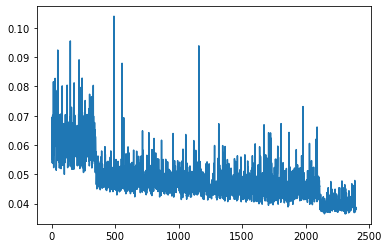

In [38]:
plt.plot(history.history['loss'][100:])

In [21]:
u_pred = u.eval(m,[xesp,yesp,tesp])
v_pred = v.eval(m,[xesp,yesp,tesp])
p_pred = p.eval(m,[xesp,yesp,tesp])

In [16]:
len(np.unique(tesp))

150

In [30]:
cm.coolwarm

In [10]:
def lee_u(u_file):
    values = []
    times = []
    fd = open(u_file,'r')
    for tupla in fd.read().split('\n\n'):
        if tupla != '':
            tiempo, datos = tupla.split('\n')
            times.append(float(tiempo))
            vector = []
            for value in datos.split('\t'):
                    if value != '':
                        vector.append(float(value))
            values.append(vector)
    values = np.array(values)
    fd.close()
    return times, values

def lee_mesh(mesh_file):
    fd = open(mesh_file)
    for batch in fd.read().split('\n\n'):
        if batch[0:8]=='Vertices':
            vertices = batch
    fd.close()

    coordenadas = []

    for vertice in vertices.split('\n'):
        if len(vertice.split(' ')) == 3:
            coordenadas.append([float(vertice.split(' ')[0]),float(vertice.split(' ')[1])])
    coordenadas = np.array(coordenadas)
    return coordenadas

def preparadatos(u_file,mesh_file):
    datos = lee_u(u_file)
    mesh = lee_mesh(mesh_file)
    
    sec = datos[0][0]
    fullmesh = np.insert(mesh,2,sec,axis=1)
    
    for i in range(1,len(datos[0])):
        sec = datos[0][i]
        fullmesh = np.append(fullmesh,np.insert(mesh,2,sec,axis=1),axis=0)
    
    valores = datos[1].flatten()
    
    return fullmesh,valores

from scipy.interpolate import griddata

In [11]:
#Archivos de datos
u_file = 'u.txt'
v_file = 'v.txt'
p_file = 'p.txt'
mesh_file = 'wtunnel'
#Predicciones del numérico
puntos, u_valores = preparadatos(u_file,mesh_file)

puntos, v_valores = preparadatos(v_file,mesh_file)

puntos, p_valores = preparadatos(p_file,mesh_file)

print('Datos preparados')
u_pred_Num = griddata(puntos, u_valores, esp , method='nearest')
v_pred_Num = griddata(puntos, v_valores, esp , method='nearest')
p_pred_Num = griddata(puntos, p_valores, esp , method='nearest')

Datos preparados


In [46]:
len(np.unique(tesp))

150

0.0
15.100671140939596
30.0


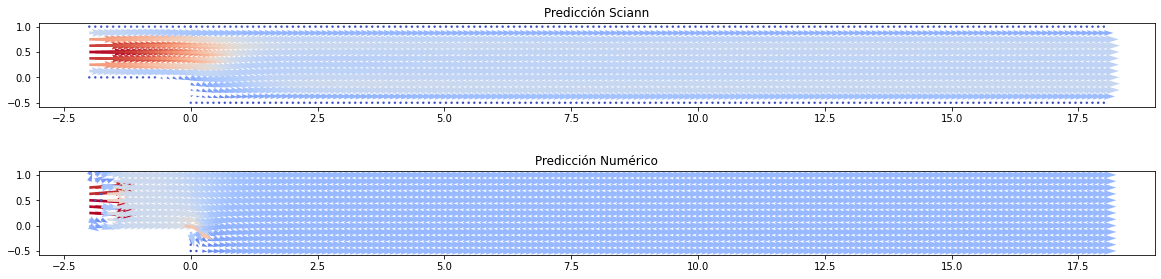

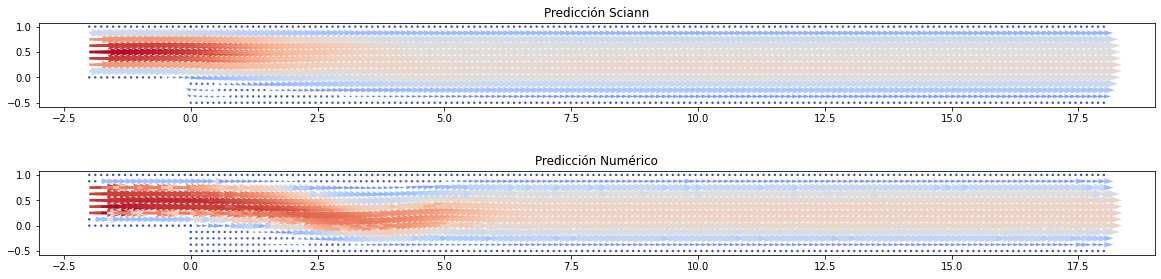

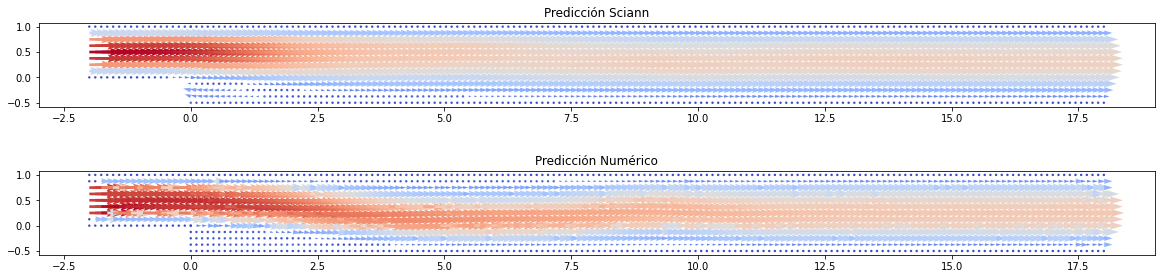

In [22]:
for index in [0,75,149]:
    tindex = np.where(tesp==np.unique(tesp)[index])[0]
    print(np.unique(tesp)[index])

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    vectornorm = np.sqrt(u_pred**2+v_pred**2)
    vectorrot = np.arctan2(u_pred,v_pred)
    ax.title.set_text('Predicción Sciann')
    ax.quiver(xesp[tindex],yesp[tindex],u_pred[tindex],v_pred[tindex],vectornorm[tindex],cmap=cm.coolwarm)
    ax.set_aspect('equal')

    ax2=fig.add_subplot(212)

    vectornorm_Num = np.sqrt(u_pred_Num**2+v_pred_Num**2)

    ax2.quiver(xesp[tindex],yesp[tindex],u_pred_Num[tindex],v_pred_Num[tindex],vectornorm_Num[tindex],cmap=cm.coolwarm)
    ax2.set_aspect('equal')
    ax2.title.set_text('Predicción Numérico')
    fig.savefig('First_5_Comparación en t='+str(np.unique(tesp[index])[0])+'.jpg')

0.0
15.100671140939596
30.0


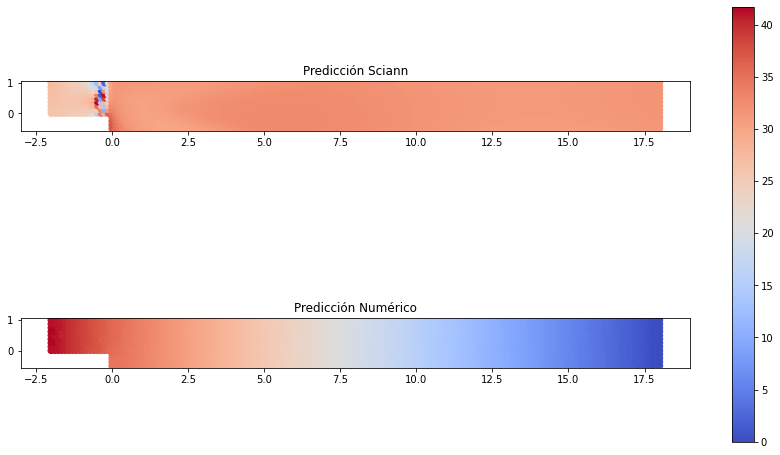

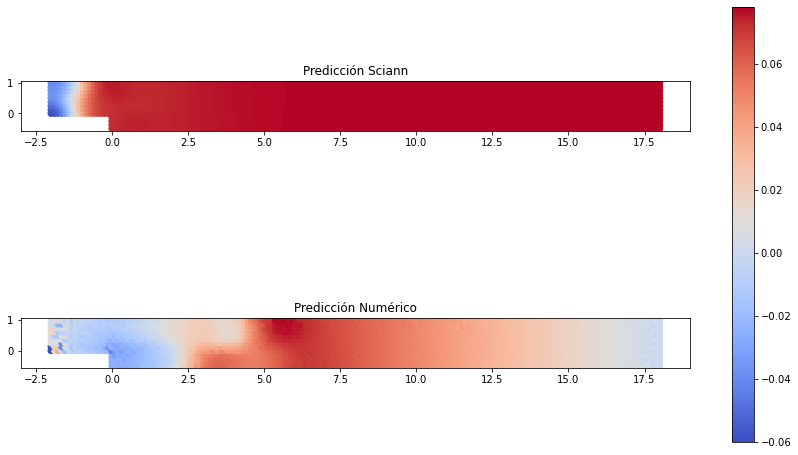

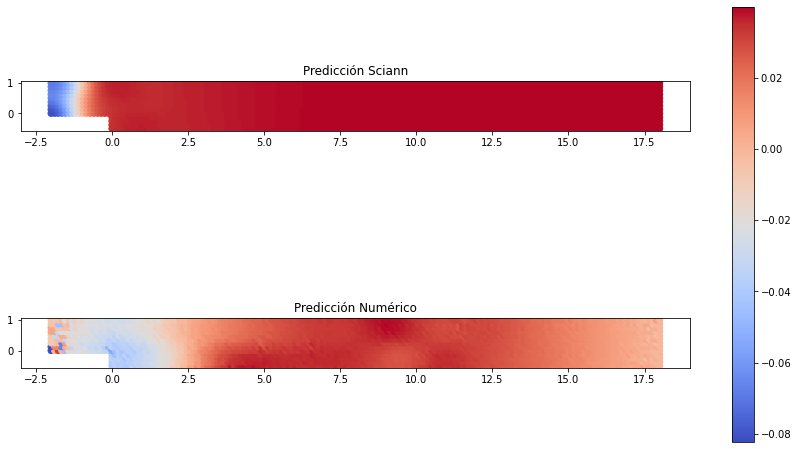

In [111]:
for index in [0,75,149]:

    tindex = np.where(tesp==np.unique(tesp)[index])[0]
    print(np.unique(tesp)[index])

    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(15,8))
    im = axes[0].scatter(xesp[tindex],yesp[tindex],c=p_pred[tindex],cmap=cm.coolwarm)
    axes[0].set_aspect('equal')
    axes[0].title.set_text('Predicción Sciann')

    im = axes[1].scatter(xesp[tindex],yesp[tindex],c=p_pred_Num[tindex],cmap=cm.coolwarm)
    axes[1].set_aspect('equal')
    axes[1].title.set_text('Predicción Numérico')

    fig.colorbar(im, ax=axes.ravel().tolist())
    
    fig.savefig('Comparación de presión en t='+str(np.unique(tesp[index])[0])+'.jpg')

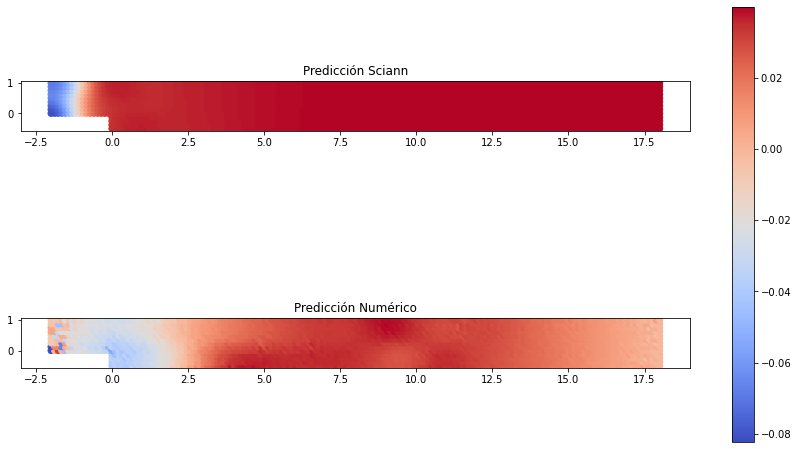

0.8356545961002786


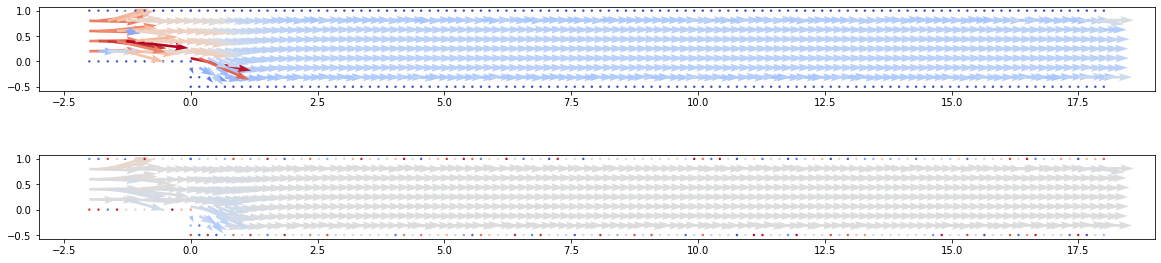

In [202]:
index = 5
tindex = np.where(tesp==np.unique(tesp)[index])[0]
print(np.unique(tesp)[index])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

vectornorm = np.sqrt(u_pred_Num**2+v_pred_Num**2)
vectorrot = np.arctan2(v_pred_Num,u_pred_Num)

ax.quiver(xesp[tindex],yesp[tindex],u_pred_Num[tindex],v_pred_Num[tindex],vectornorm[tindex],cmap=cm.coolwarm)
ax.set_aspect('equal')

ax2=fig.add_subplot(212)

ax2.quiver(xesp[tindex],yesp[tindex],u_pred_Num[tindex],v_pred_Num[tindex],vectorrot[tindex],cmap=cm.coolwarm)
ax2.set_aspect('equal')

37.60445682451253


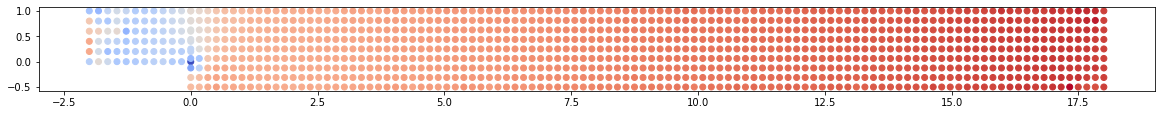

In [203]:
tindex = np.where(tesp==np.unique(tesp)[3])[0]
print(np.unique(tesp)[225])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.scatter(xesp[tindex],yesp[tindex],c=p_pred_Num[tindex],cmap=cm.coolwarm)
ax.set_aspect('equal')

In [101]:
uniquet = np.unique(tesp)
indsliced = [np.where(tesp==tiempo)[0] for tiempo in uniquet]

[np.mean(np.sqrt(u_error[tiempo]**2+v_error[tiempo]**2)) for tiempo in indsliced]

[0.4113140446054521,
 0.4077250281563278,
 0.3238532821899715,
 0.3171089807559151,
 0.31685175030531504,
 0.314782274117776,
 0.31470729699775074,
 0.31515595461874435,
 0.3162289609118108,
 0.3163891260649763,
 0.3163695511505172,
 0.3167421784110628,
 0.31712008734940306,
 0.31769452611144505,
 0.3182275813146216,
 0.318659620754916,
 0.31868072253964935,
 0.3189548205068697,
 0.3194754641607059,
 0.3198697388709069,
 0.32011858359498374,
 0.3205907144004558,
 0.32060720946370097,
 0.3208703121049489,
 0.3212028569488873,
 0.32182800456369365,
 0.3220890904620673,
 0.3224521077016095,
 0.3224609380676322,
 0.3227325855339138,
 0.3235290611814408,
 0.32408082865611854,
 0.324357500875269,
 0.32512872683007854,
 0.3251327506001674,
 0.3254229697768605,
 0.3257782508240584,
 0.32582507019063095,
 0.32631361606484804,
 0.32672169590288874,
 0.3267241271474544,
 0.32709201187728637,
 0.3276500664090688,
 0.32792737038871445,
 0.3284556613055692,
 0.3286810967862993,
 0.32868206894355334,

In [65]:
u_error = np.abs(u_pred-u_pred_Num)
v_error = np.abs(v_pred-v_pred_Num)
p_error = np.abs(p_pred-p_pred_Num)

vectornorm_error = np.mean(np.sqrt(u_error**2+v_error**2))
vectornorm_error

print(np.mean(u_error),np.mean(v_error),np.mean(p_error))

0.332065425146745 0.01565221802370789 0.19972877985403897


In [67]:
L1_u = np.mean(u_error)*870
L1_v = np.mean(v_error)*870
L1_p = np.mean(p_error)*870

MAX_u = np.max(u_error)
MAX_v = np.max(v_error)
MAX_p = np.max(p_error)


print(L1_u,L1_v,L1_p)
print(MAX_u,MAX_v,MAX_p)

288.89691987766815 13.617429680625863 173.7640384730139
1.3050927916172905 0.6532640590896363 41.69357692165907


In [69]:
tesp[np.where(p_error==MAX_p)[0]]

array([0.])

In [63]:
xesp.shape[0]/denspt

37800.0

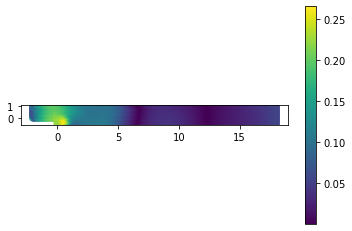

In [42]:
plt.scatter(xesp[tindex],yesp[tindex],c=p_error[tindex])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect('equal')
plt.colorbar()

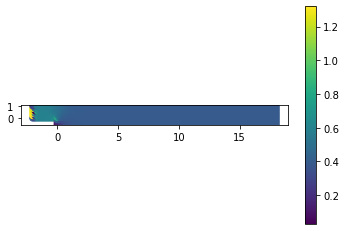

In [97]:
vectornorm = np.sqrt(u_error**2+v_error**2)
plt.scatter(xesp[tindex],yesp[tindex],c=vectornorm[tindex])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect('equal')
plt.colorbar()

In [38]:
print(u_pred_Num.max()-u_pred_Num.min())
print(v_pred_Num.max()-v_pred_Num.min())
print(p_pred_Num.max()-p_pred_Num.min())

1.8469818275
1.2581601108
42.624536990799996


In [40]:
np.max(p_error)

41.689928041575726